# Preprocessing of BacDrop data

In [1]:
import scanpy as sc
import mudata as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from scipy import stats

import sys
sys.path.append('../')
from utils.utils import calc_sparsity, fetch_protein_names, is_outlier

In [2]:
path_nSBM = '../data/raw/mudata_nSBM_hierarchy_2_final_4_species.h5mu'

In [3]:
data_nSBM = md.read_h5mu(path_nSBM)
data_nSBM

MuData object with n_obs × n_vars = 36469 × 33412
  3 modalities
    SC_genes:	36469 x 14009
      obs:	'strains'
      var:	'strains', 'matchin_protein', 'protein'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
    SC_proteins:	36469 x 13687
      obs:	'strains'
      var:	'genes_mapping', 'strains'
      uns:	'Consensus_tree', 'protein_adjacency_matrix', 'protein_match', 'protein_unmatch'
      varm:	'protein_hierarchy'
    SC_PCs:	36469 x 5716
      obs:	'strains'
      var:	'PCs_match'
      uns:	'Consensus_tree_PCs', 'PCs', 'PCs_to_genes', 'PCs_unmatch', 'Purity_info', 'Purity_info_unique', 'protein_match'
      varm:	'protein_hierarchy_PCs'

In [4]:
data_gex = data_nSBM['SC_genes'].copy()
data_gex

AnnData object with n_obs × n_vars = 36469 × 14009
    obs: 'strains'
    var: 'strains', 'matchin_protein', 'protein'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

In [5]:
data_gex.obs.strains.value_counts()

strains
GSM5456504_Efm_CDS    9975
GSM5456503_Ec_CDS     9654
GSM5456506_Kp_CDS     8648
GSM5456505_PsA_CDS    8192
Name: count, dtype: int64

         Falling back to preprocessing with `sc.pp.pca` and default params.


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


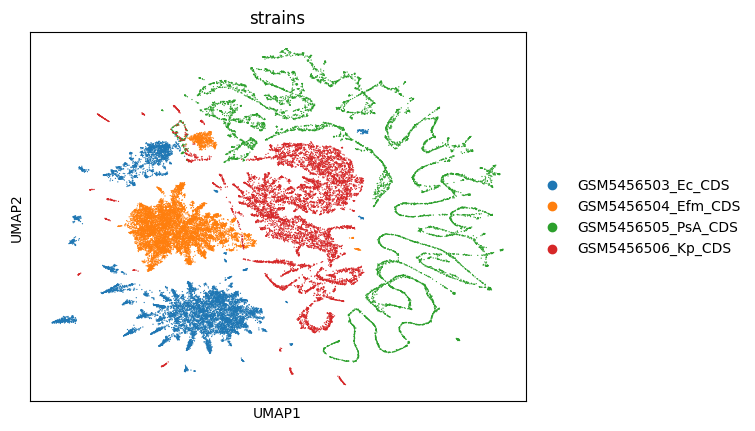

In [6]:
sc.pp.neighbors(data_gex, n_neighbors=15)
sc.tl.umap(data_gex)
sc.pl.umap(data_gex, color=["strains"])

In [7]:
print("Sparity:\t\t", calc_sparsity(data_gex.X.A))
print("Mean counts per gene:\t", np.mean(np.sum(data_gex.X.A, axis=1)))
print("Median counts per gene:\t", np.median(np.sum(data_gex.X.A, axis=1)))
print("Mean genes per cell: \t", np.mean(np.sum(data_gex.X.A, axis=0)))
print("Median genes per cell:\t", np.median(np.sum(data_gex.X.A, axis=0)))

Sparity:		 0.9994290872982883
Mean counts per gene:	 7.997916
Median counts per gene:	 5.0
Mean genes per cell: 	 20.820616
Median genes per cell:	 3.0


In [5]:
sc.pp.calculate_qc_metrics(data_gex, var_type="genes", percent_top=None, log1p=False, inplace=True)
data_gex

AnnData object with n_obs × n_vars = 36469 × 14009
    obs: 'strains', 'n_genes_by_counts', 'total_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

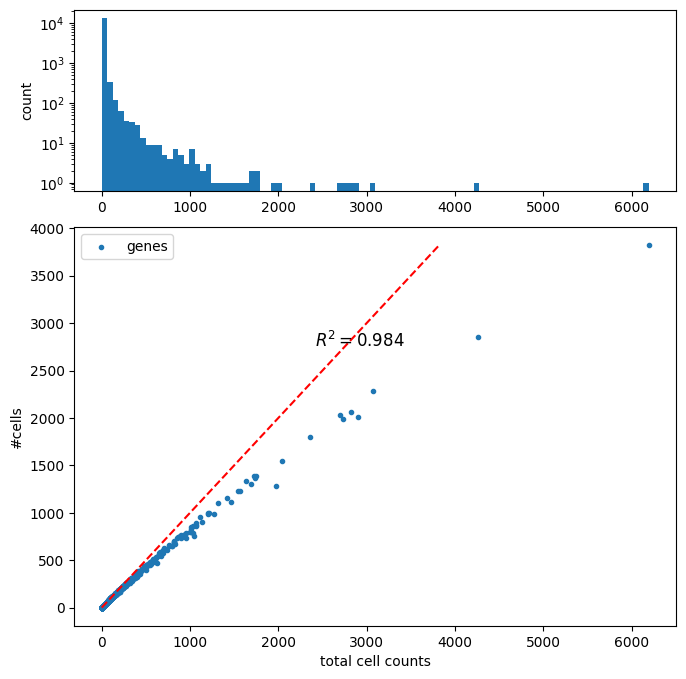

In [9]:
slope, intercept, r_value, p_value, std_err = stats.linregress(data_gex.var.n_cells_by_counts, data_gex.var.total_counts)
r_squared_genes = r_value ** 2
r_squared_genes

lim  = min(data_gex.var.n_cells_by_counts.max(), data_gex.var.total_counts.max())
line = [0, lim]

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 3)

ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2])

ax_main.scatter(data=data_gex.var, x="total_counts" , y="n_cells_by_counts", marker='.', label="genes")
ax_main.plot(line, line, color='red', linestyle="--")
ax_main.set(xlabel="total cell counts", ylabel="#cells")
ax_main.text(0.4, 0.7, f'$R^2 = {r_squared_genes:.3f}$', fontsize=12, transform=ax_main.transAxes)
ax_main.legend()

bins = np.arange(0, lim, 100)

ax_xDist.hist(data_gex.var["total_counts"], bins=100, align='mid')
ax_xDist.set(ylabel='count')
ax_xDist.set_yscale('log')
#ax_xDist.set_xlim(0, 10000)


plt.show()

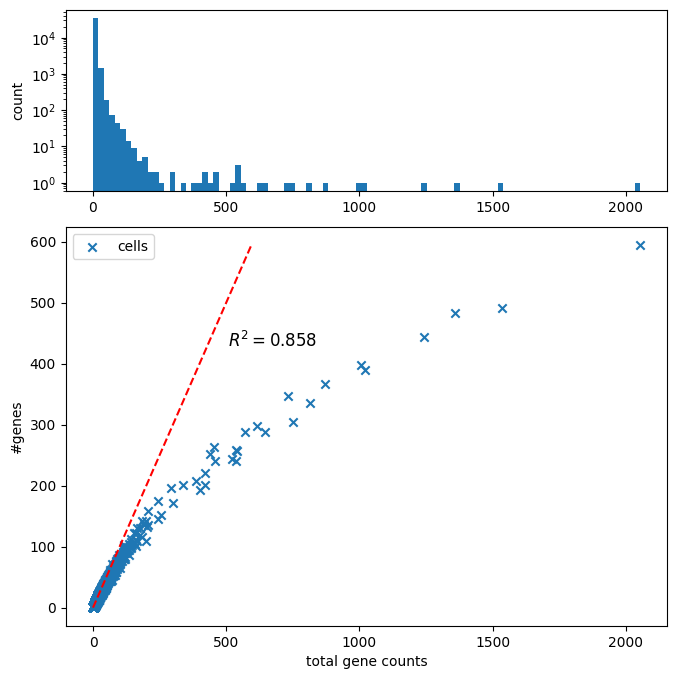

In [10]:
slope, intercept, r_value, p_value, std_err = stats.linregress(data_gex.obs.n_genes_by_counts, data_gex.obs.total_counts)
r_squared_cells = r_value ** 2
r_squared_cells

lim  = min(data_gex.obs.n_genes_by_counts.max(), data_gex.obs.total_counts.max())
line = [0, lim]

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 3)

ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2])

ax_main.scatter(data=data_gex.obs, x="total_counts" , y="n_genes_by_counts", marker='x', label="cells")
ax_main.plot(line, line, color='red', linestyle="--")
ax_main.set(xlabel="total gene counts", ylabel="#genes")
ax_main.text(0.27, 0.7, f'$R^2 = {r_squared_cells:.3f}$', fontsize=12, transform=ax_main.transAxes)
ax_main.legend()

bins = np.arange(0, lim, 100)

ax_xDist.hist(data_gex.obs["total_counts"], bins=100, align='mid')
ax_xDist.set(ylabel='count')
ax_xDist.set_yscale('log')
#ax_xDist.set_xlim(0, 10000)


plt.show()

### Splitting the data strain-specific

In [6]:
strain_names = ["GSM5456503_Ec_CDS", "GSM5456504_Efm_CDS", "GSM5456505_PsA_CDS", "GSM5456506_Kp_CDS"]
strain_ids = ["ec", "efm", "psa", "kp"]

print('Original data shape (n x p):\t', data_gex.shape)
print('--------------------------------------------------')

data_gex_ec = data_gex[data_gex.obs['strains'] == 'GSM5456503_Ec_CDS'].copy()
print('original ec data shape:\t\t', data_gex_ec.shape)
sc.pp.filter_genes(data_gex_ec, min_cells=1)
sc.pp.calculate_qc_metrics(data_gex_ec, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_ec.shape)
print('--------------------------------------------------')

data_gex_efm = data_gex[data_gex.obs['strains'] == 'GSM5456504_Efm_CDS'].copy()
print('original efm data shape:\t', data_gex_efm.shape)
sc.pp.filter_genes(data_gex_efm, min_cells=1)
sc.pp.calculate_qc_metrics(data_gex_efm, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_efm.shape)
print('--------------------------------------------------')

data_gex_psa = data_gex[data_gex.obs['strains'] == 'GSM5456505_PsA_CDS'].copy()
print('original psa data shape:\t', data_gex_psa.shape)
sc.pp.filter_genes(data_gex_psa, min_cells=1)
sc.pp.calculate_qc_metrics(data_gex_psa, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_psa.shape)

data_gex_kp = data_gex[data_gex.obs['strains'] == 'GSM5456506_Kp_CDS'].copy()
print('Original kp data shape:\t\t', data_gex_kp.shape)
sc.pp.filter_genes(data_gex_kp, min_cells=1)
sc.pp.calculate_qc_metrics(data_gex_kp, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_kp.shape)
print('--------------------------------------------------')

Original data shape (n x p):	 (36469, 14009)
--------------------------------------------------
original ec data shape:		 (9654, 14009)
Strain specific genes shape:	 (9654, 3642)
--------------------------------------------------
original efm data shape:	 (9975, 14009)
Strain specific genes shape:	 (9975, 2350)
--------------------------------------------------
original psa data shape:	 (8192, 14009)
Strain specific genes shape:	 (8192, 3478)
Original kp data shape:		 (8648, 14009)
Strain specific genes shape:	 (8648, 4539)
--------------------------------------------------


### Annotating the genes with their NCBI names 
Names fetched from NCBI and categorizing them as rRNA if their name contains "ribosomal subunit"

In [7]:
ec_matching_genes = data_gex_ec.var[data_gex_ec.var["matchin_protein"] != "no_match"]
ec_accession_numbers = ec_matching_genes['protein'].tolist()
ec_protein_names = fetch_protein_names(ec_accession_numbers)
ec_gene_to_protein = dict(zip(ec_accession_numbers, ec_protein_names))
data_gex_ec.var['protein_name'] = data_gex_ec.var['protein'].map(ec_gene_to_protein)
data_gex_ec.var["protein_name"].fillna("None", inplace=True)
data_gex_ec.var["rRNA"] = data_gex_ec.var["protein_name"].str.contains('ribosomal\s(?:subunit|protein)').values
data_gex_ec.var["rRNA"].value_counts()

100%|██████████| 26753/26753 [00:00<00:00, 3822524.78it/s]


rRNA
False    3582
True       60
Name: count, dtype: int64

In [8]:
efm_matching_genes = data_gex_efm.var[data_gex_efm.var["matchin_protein"] != "no_match"]
efm_accession_numbers = efm_matching_genes['protein'].tolist()
efm_protein_names = fetch_protein_names(efm_accession_numbers)
efm_gene_to_protein = dict(zip(efm_accession_numbers, efm_protein_names))
data_gex_efm.var['protein_name'] = data_gex_efm.var['protein'].map(efm_gene_to_protein)
data_gex_efm.var["protein_name"].fillna("None", inplace=True)
data_gex_efm.var["rRNA"] = data_gex_efm.var["protein_name"].str.contains('ribosomal\s(?:subunit|protein)').values
data_gex_efm.var["rRNA"].value_counts()

100%|██████████| 16402/16402 [00:00<00:00, 3280950.70it/s]


rRNA
False    2290
True       60
Name: count, dtype: int64

In [9]:
psa_matching_genes = data_gex_psa.var[data_gex_psa.var["matchin_protein"] != "no_match"]
psa_accession_numbers = psa_matching_genes['protein'].tolist()
psa_protein_names = fetch_protein_names(psa_accession_numbers)
psa_gene_to_protein = dict(zip(psa_accession_numbers, psa_protein_names))
data_gex_psa.var['protein_name'] = data_gex_psa.var['protein'].map(psa_gene_to_protein)
#no non-matching proteins in psa
data_gex_psa.var["protein_name"] = data_gex_psa.var["protein_name"].astype("object")
data_gex_psa.var["rRNA"] = data_gex_psa.var["protein_name"].str.contains('ribosomal\s(?:subunit|protein)').values
data_gex_psa.var["rRNA"].value_counts()

100%|██████████| 27457/27457 [00:00<00:00, 3922579.27it/s]


rRNA
False    3420
True       58
Name: count, dtype: int64

In [10]:
kp_matching_genes = data_gex_kp.var[data_gex_kp.var["matchin_protein"] != "no_match"]
kp_accession_numbers = kp_matching_genes['protein'].tolist()
kp_protein_names = fetch_protein_names(kp_accession_numbers)
kp_gene_to_protein = dict(zip(kp_accession_numbers, kp_protein_names))
data_gex_kp.var['protein_name'] = data_gex_kp.var['protein'].map(kp_gene_to_protein)
data_gex_kp.var["protein_name"].fillna("None", inplace=True)
data_gex_kp.var["rRNA"] = data_gex_kp.var["protein_name"].str.contains('ribosomal\s(?:subunit|protein)').values
data_gex_kp.var["rRNA"].value_counts()

100%|██████████| 32305/32305 [00:00<00:00, 3589799.73it/s]


rRNA
False    4479
True       60
Name: count, dtype: int64

### Adding Protein Cluster Information
Adding for each gene its corresponding protein cluster information

In [69]:
# adding PC for genes without protein annotation
data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc["no_match"] = ["no_match"]*8

for key in data_nSBM["SC_proteins"].varm["protein_hierarchy"].keys()[:-1]: # [:-1] exclude root because same for all
    data_gex_ec.var[f'PC_{key}'] = data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[data_gex_ec.var["protein"]][key].values
    data_gex_efm.var[f'PC_{key}'] = data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[data_gex_efm.var["protein"]][key].values
    data_gex_psa.var[f'PC_{key}'] = data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[data_gex_psa.var["protein"]][key].values
    data_gex_kp.var[f'PC_{key}'] = data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[data_gex_kp.var["protein"]][key].values

### Filtering Cells

Based on current best practices [1] filter cells with 
- Abnormal high count depth such as doublets
- Cells with very low count depth 

[1] Luecken, M. D. & Theis, F. J. Current best practices in single-cell rna-seq analysis: a tutorial. Molecular systems biology 15, e8746 (2019)

In [11]:
sc.pp.calculate_qc_metrics(data_gex, var_type="genes", percent_top=None, log1p=True, inplace=True)

sc.pp.calculate_qc_metrics(data_gex_ec, var_type="genes", qc_vars=["rRNA"], percent_top=None, log1p=True, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_efm, var_type="genes", qc_vars=["rRNA"], percent_top=None, log1p=True, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_psa, var_type="genes", qc_vars=["rRNA"], percent_top=None, log1p=True, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_kp, var_type="genes", qc_vars=["rRNA"], percent_top=None, log1p=True, inplace=True)

In [12]:
data_gex_ec.obs["outlier"] = (is_outlier(data_gex_ec, "log1p_total_counts", nmads=5) | 
                              is_outlier(data_gex_ec, "log1p_n_genes_by_counts", nmads=5))
print(f"Detected {data_gex_ec.obs.outlier.sum()} outliers in EC.")

data_gex_efm.obs["outlier"] = (is_outlier(data_gex_efm, "log1p_total_counts", nmads=5) | 
                              is_outlier(data_gex_efm, "log1p_n_genes_by_counts", nmads=5))
print(f"Detected {data_gex_efm.obs.outlier.sum()} outliers in EFM.")

data_gex_psa.obs["outlier"] = (is_outlier(data_gex_psa, "log1p_total_counts", nmads=5) | 
                              is_outlier(data_gex_psa, "log1p_n_genes_by_counts", nmads=5))
print(f"Detected {data_gex_psa.obs.outlier.sum()} outliers in PSA.")

data_gex_kp.obs["outlier"] = (is_outlier(data_gex_kp, "log1p_total_counts", nmads=5) | 
                              is_outlier(data_gex_kp, "log1p_n_genes_by_counts", nmads=5))
print(f"Detected {data_gex_kp.obs.outlier.sum()} outliers in KP.")

Detected 32 outliers in EC.
Detected 108 outliers in EFM.
Detected 63 outliers in PSA.
Detected 91 outliers in KP.


<Axes: title={'center': 'outlier'}, xlabel='total_counts', ylabel='n_genes_by_counts'>

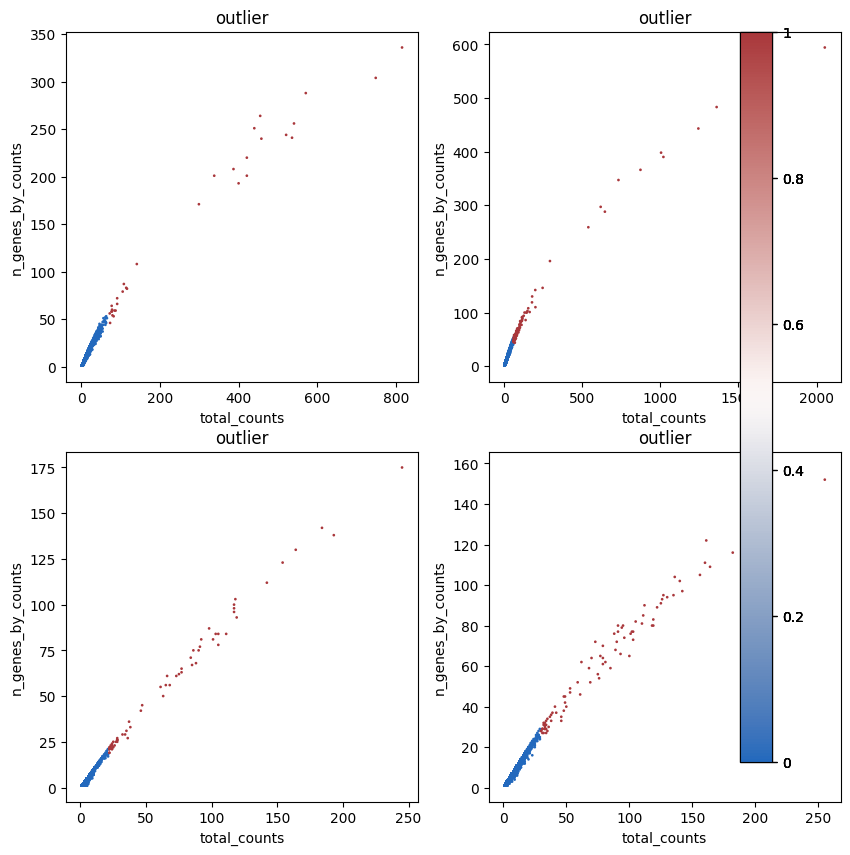

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sc.pl.scatter(data_gex_ec, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="vlag", ax=axes[0, 0])
sc.pl.scatter(data_gex_efm, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="vlag", ax=axes[0, 1])
sc.pl.scatter(data_gex_psa, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="vlag", ax=axes[1, 0])
sc.pl.scatter(data_gex_kp, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="vlag", ax=axes[1, 1])


In [13]:
print(data_gex_ec.shape)
data_gex_ec = data_gex_ec[~data_gex_ec.obs["outlier"]].copy()
print(data_gex_ec.shape)

(9654, 3642)
(9622, 3642)


In [14]:
print(data_gex_efm.shape)
data_gex_efm = data_gex_efm[~data_gex_efm.obs["outlier"]].copy()
print(data_gex_efm.shape)

(9975, 2350)
(9867, 2350)


In [15]:
print(data_gex_psa.shape)
data_gex_psa = data_gex_psa[~data_gex_psa.obs["outlier"]].copy()
print(data_gex_psa.shape)

(8192, 3478)
(8129, 3478)


In [16]:
print(data_gex_kp.shape)
data_gex_kp = data_gex_kp[~data_gex_kp.obs["outlier"]].copy()
print(data_gex_kp.shape)

(8648, 4539)
(8557, 4539)


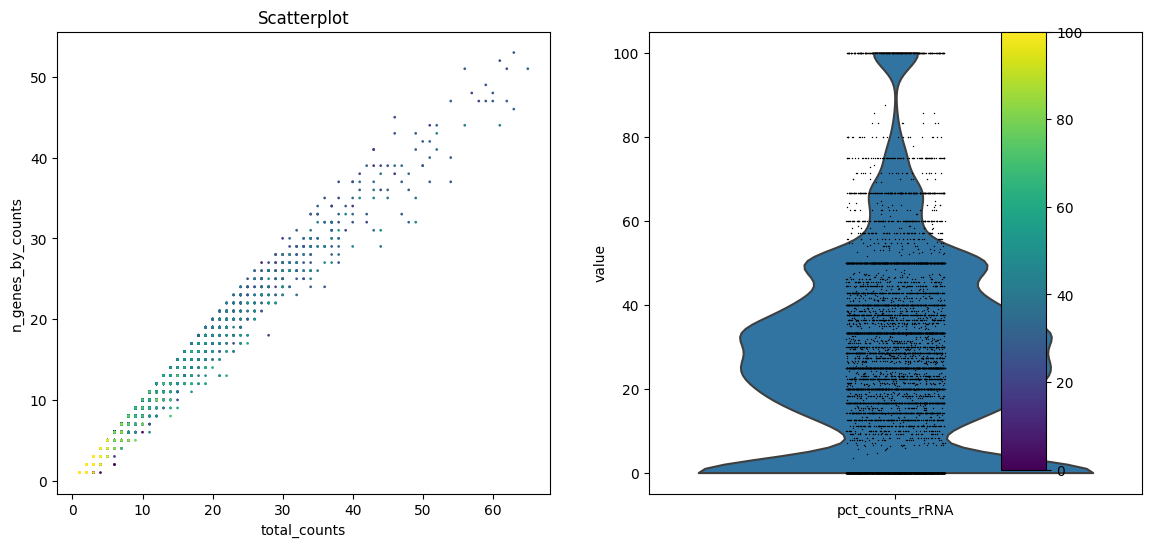

<Figure size 640x480 with 0 Axes>

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sc.pl.scatter(data_gex_ec, "total_counts", "n_genes_by_counts", color="pct_counts_rRNA", show=False, size=15, color_map="viridis", ax=axes[0])
axes[0].set_title('Scatterplot')

sc.pl.violin(data_gex_ec, keys="pct_counts_rRNA", ax=axes[1])
axes[1].set_title('Violinplot')

plt.tight_layout()

plt.show()

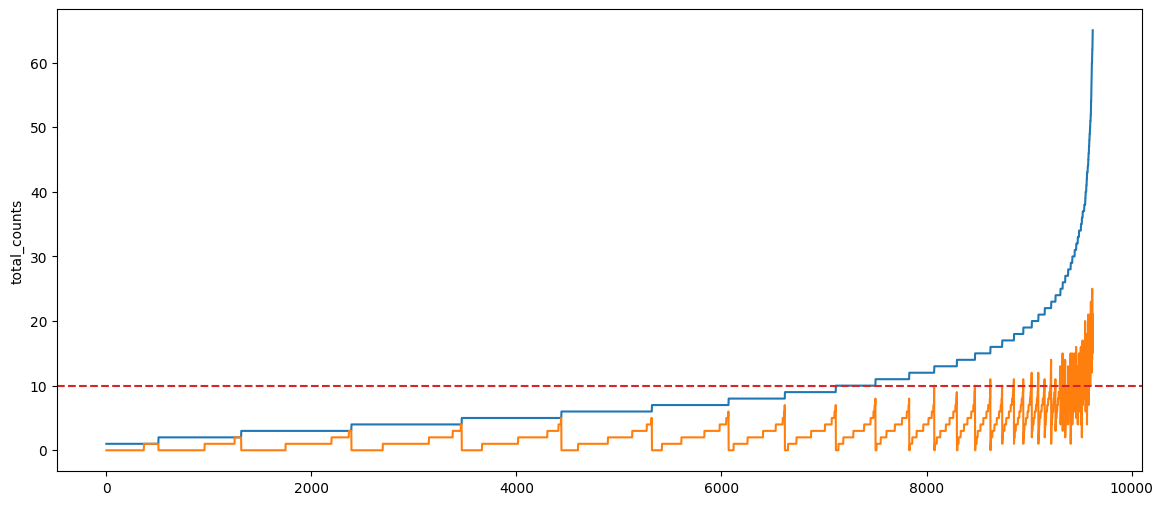

In [103]:
sorted_ec = data_gex_ec.obs.copy()
sorted_ec["total_counts_rRNA"] = sorted_ec["total_counts"] * (sorted_ec["pct_counts_rRNA"] / 100)
sorted_ec = sorted_ec.sort_values(by=["total_counts", "total_counts_rRNA"], inplace=False)

#the higher the percentage the brighter the color?
#rRNA seems to be stable
plt.figure(figsize=(14, 6))
sns.lineplot(x=np.arange(len(data_gex_ec.obs)), y=sorted_ec.total_counts)
sns.lineplot(x=np.arange(len(data_gex_ec.obs)), y=sorted_ec.total_counts_rRNA)
plt.axhline(y=10, color="C3", ls="--")

<Axes: ylabel='pct_counts_rRNA'>

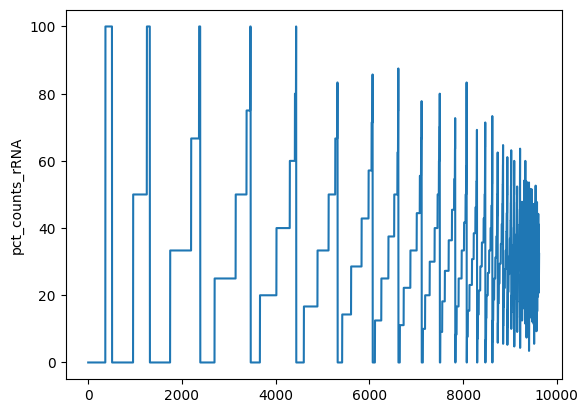

In [101]:
sns.lineplot(x=np.arange(len(data_gex_ec.obs)), y=sorted_ec.pct_counts_rRNA)

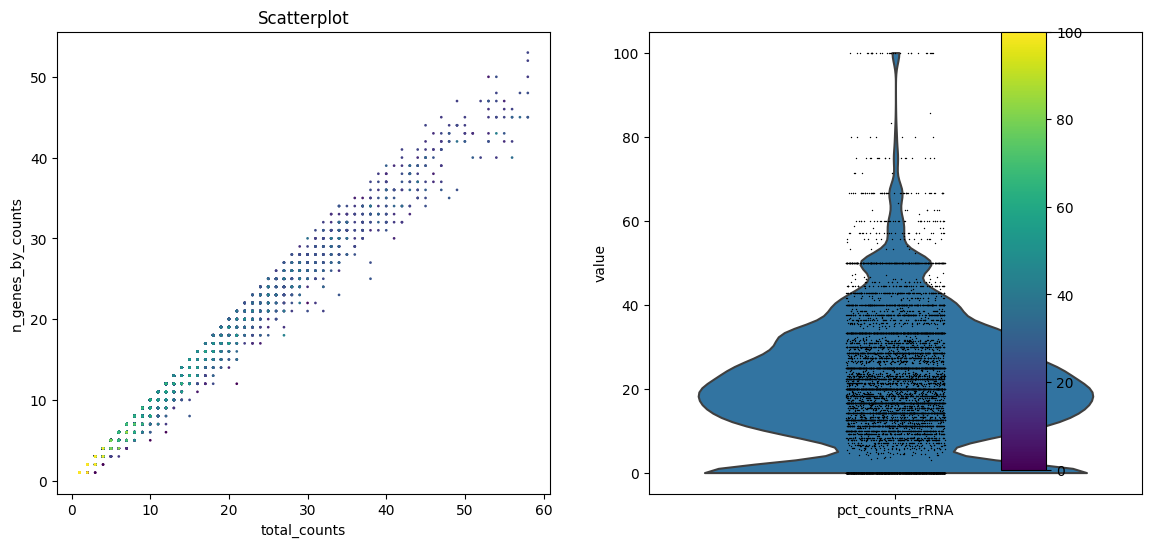

<Figure size 640x480 with 0 Axes>

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sc.pl.scatter(data_gex_efm, "total_counts", "n_genes_by_counts", color="pct_counts_rRNA", show=False, size=15, color_map="viridis", ax=axes[0])
axes[0].set_title('Scatterplot')

sc.pl.violin(data_gex_efm, keys="pct_counts_rRNA", ax=axes[1])
axes[1].set_title('Violinplot')

plt.tight_layout()

plt.show()

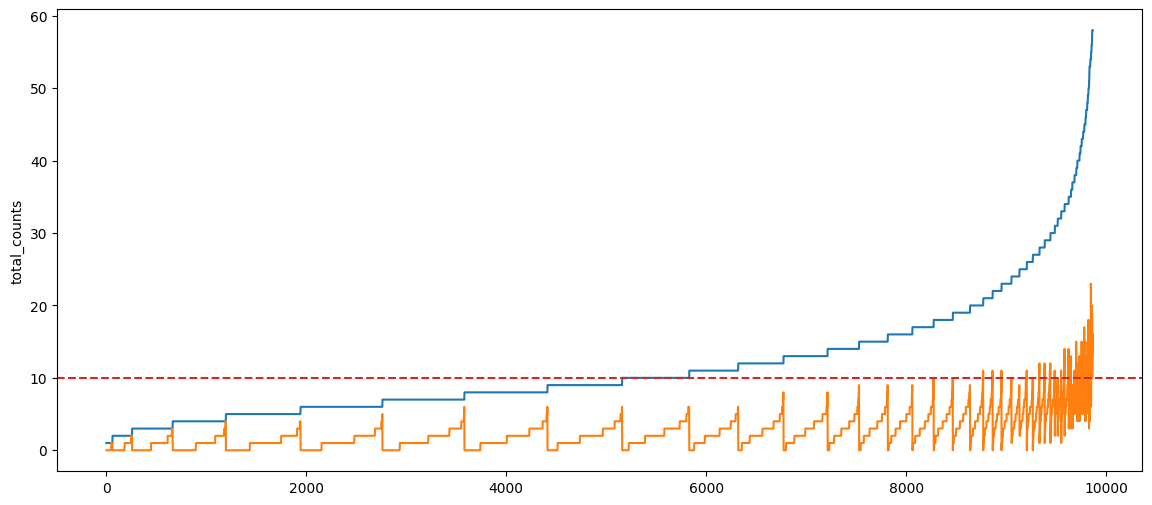

In [104]:
sorted_efm = data_gex_efm.obs.copy()
sorted_efm["total_counts_rRNA"] = sorted_efm["total_counts"] * (sorted_efm["pct_counts_rRNA"] / 100)
sorted_efm = sorted_efm.sort_values(by=["total_counts", "total_counts_rRNA"], inplace=False)

#the higher the percentage the brighter the color?
plt.figure(figsize=(14, 6))
sns.lineplot(x=np.arange(len(data_gex_efm.obs)), y=sorted_efm.total_counts)
sns.lineplot(x=np.arange(len(data_gex_efm.obs)), y=sorted_efm.total_counts_rRNA)
plt.axhline(y=10, color="C3", ls="--")

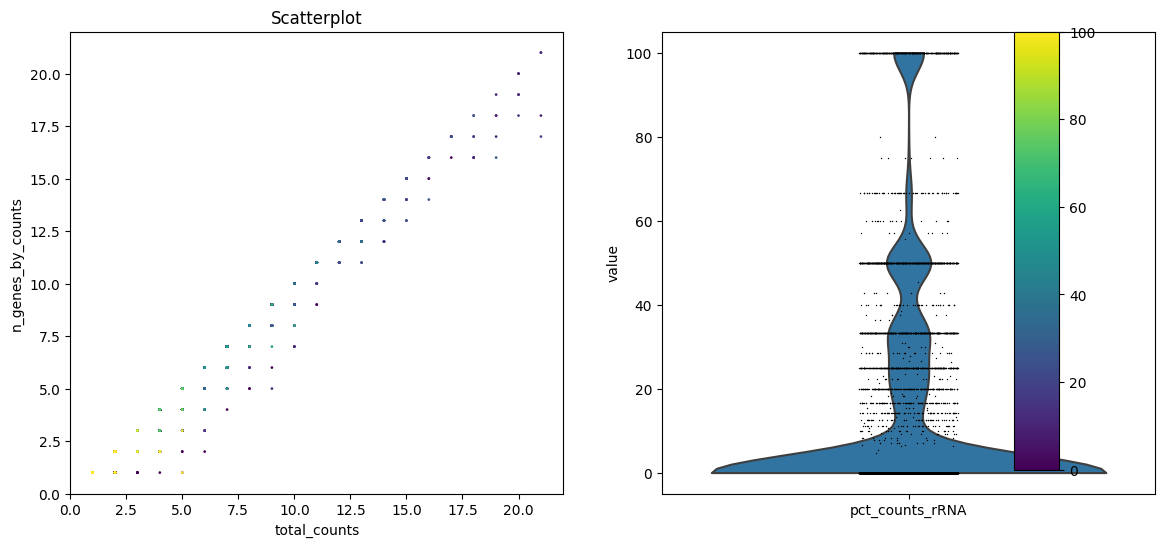

<Figure size 640x480 with 0 Axes>

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sc.pl.scatter(data_gex_psa, "total_counts", "n_genes_by_counts", color="pct_counts_rRNA", show=False, size=15, color_map="viridis", ax=axes[0])
axes[0].set_title('Scatterplot')

sc.pl.violin(data_gex_psa, keys="pct_counts_rRNA", ax=axes[1])
axes[1].set_title('Violinplot')

plt.tight_layout()

plt.show()

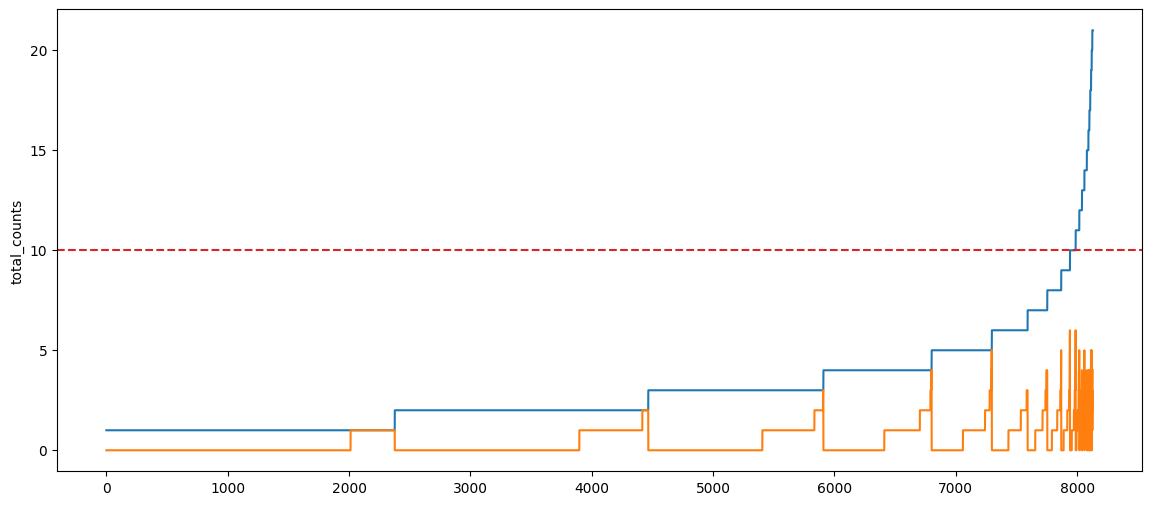

In [105]:
sorted_psa = data_gex_psa.obs.copy()
sorted_psa["total_counts_rRNA"] = sorted_psa["total_counts"] * (sorted_psa["pct_counts_rRNA"] / 100)
sorted_psa = sorted_psa.sort_values(by=["total_counts", "total_counts_rRNA"], inplace=False)

#the higher the percentage the brighter the color?
plt.figure(figsize=(14, 6))
sns.lineplot(x=np.arange(len(data_gex_psa.obs)), y=sorted_psa.total_counts)
sns.lineplot(x=np.arange(len(data_gex_psa.obs)), y=sorted_psa.total_counts_rRNA)
plt.axhline(y=10, color="C3", ls="--")

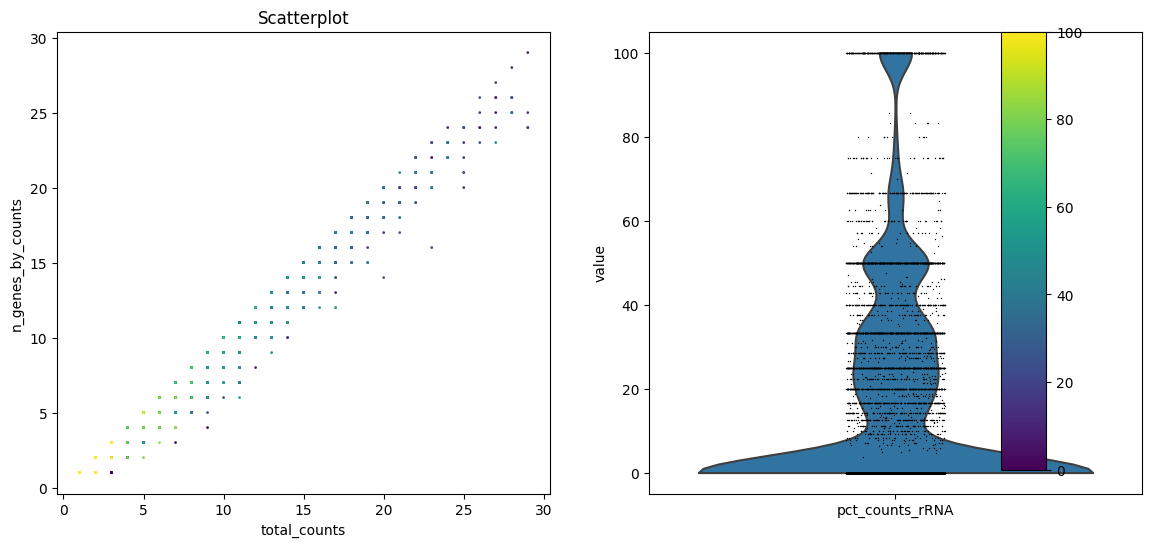

<Figure size 640x480 with 0 Axes>

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sc.pl.scatter(data_gex_kp, "total_counts", "n_genes_by_counts", color="pct_counts_rRNA", show=False, size=15, color_map="viridis", ax=axes[0])
axes[0].set_title('Scatterplot')

sc.pl.violin(data_gex_kp, keys="pct_counts_rRNA", ax=axes[1])
axes[1].set_title('Violinplot')

plt.tight_layout()

plt.show()

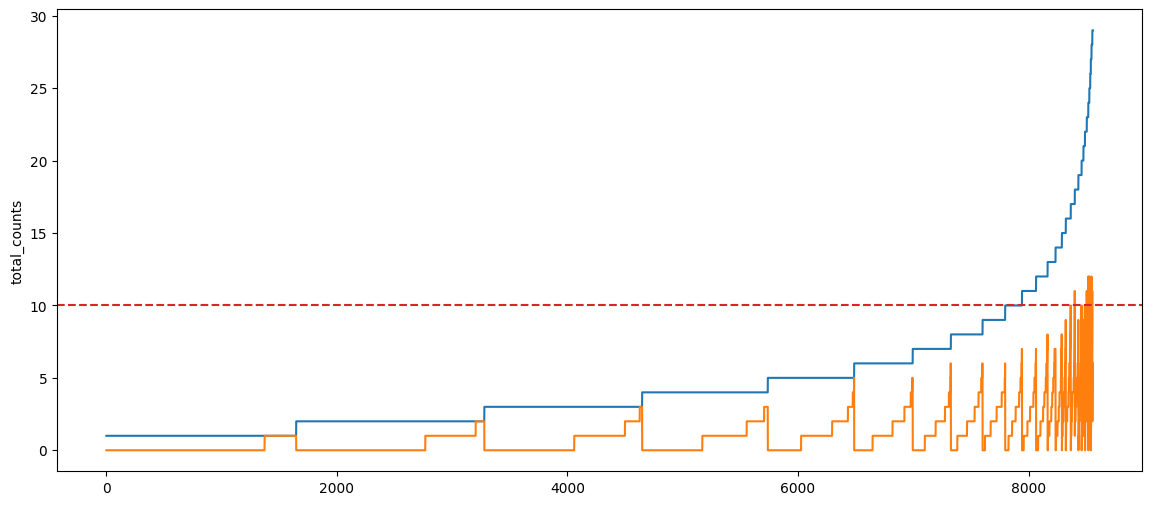

In [106]:
sorted_kp = data_gex_kp.obs.copy()
sorted_kp["total_counts_rRNA"] = sorted_kp["total_counts"] * (sorted_kp["pct_counts_rRNA"] / 100)
sorted_kp = sorted_kp.sort_values(by=["total_counts", "total_counts_rRNA"], inplace=False)

#the higher the percentage the brighter the color?
plt.figure(figsize=(14, 6))
sns.lineplot(x=np.arange(len(data_gex_kp.obs)), y=sorted_kp.total_counts)
sns.lineplot(x=np.arange(len(data_gex_kp.obs)), y=sorted_kp.total_counts_rRNA)
plt.axhline(y=10, color="C3", ls="--")

Text(0.5, 0.98, 'Count depth distribution')

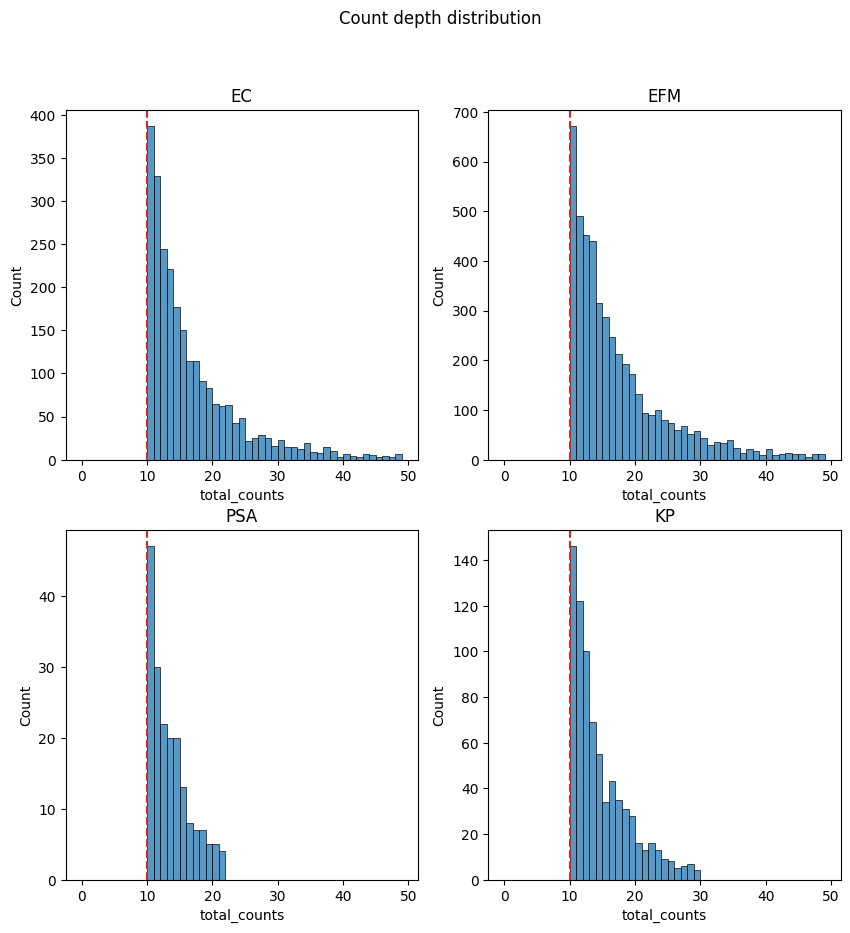

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(data_gex_ec.obs["total_counts"], bins=np.arange(50), ax=axes[0, 0])
axes[0,0].axvline(x=10, color="C3", ls="--")
sns.histplot(data_gex_efm.obs["total_counts"], bins=np.arange(50), ax=axes[0, 1])
axes[0,1].axvline(x=10, color="C3", ls="--")
sns.histplot(data_gex_psa.obs["total_counts"], bins=np.arange(50), ax=axes[1, 0])
axes[1,0].axvline(x=10, color="C3", ls="--")
sns.histplot(data_gex_kp.obs["total_counts"], bins=np.arange(50), ax=axes[1, 1])
axes[1,1].axvline(x=10, color="C3", ls="--")

axes[0,0].set_title("EC")
axes[0,1].set_title("EFM")
axes[1,0].set_title("PSA")
axes[1,1].set_title("KP")
fig.suptitle("Count depth distribution")

In [18]:
print("EC")
print('Original data shape:\t\t', data_gex_ec.shape)
sc.pp.filter_cells(data_gex_ec, min_counts=10)
sc.pp.filter_genes(data_gex_ec, min_counts=1)
sc.pp.filter_cells(data_gex_ec, min_counts=1)
print('Shape after noise removal:\t', data_gex_ec.shape)
print("EFM")
print('Original data shape:\t\t', data_gex_efm.shape)
sc.pp.filter_cells(data_gex_efm, min_counts=10)
sc.pp.filter_genes(data_gex_efm, min_counts=1)
sc.pp.filter_cells(data_gex_efm, min_counts=1)
print('Shape after noise removal:\t', data_gex_efm.shape)
print("PSA")
print('Original data shape:\t\t', data_gex_psa.shape)
sc.pp.filter_cells(data_gex_psa, min_counts=10)
sc.pp.filter_genes(data_gex_psa, min_counts=1)
sc.pp.filter_cells(data_gex_psa, min_counts=1)
print('Shape after noise removal:\t', data_gex_psa.shape)
print("KP")
print('Original data shape:\t\t', data_gex_kp.shape)
sc.pp.filter_cells(data_gex_kp, min_counts=10)
sc.pp.filter_genes(data_gex_kp, min_counts=1)
sc.pp.filter_cells(data_gex_kp, min_counts=1)
print('Shape after noise removal:\t', data_gex_kp.shape)

EC
Original data shape:		 (9622, 3642)
Shape after noise removal:	 (2507, 2622)
EFM
Original data shape:		 (9867, 2350)
Shape after noise removal:	 (4708, 2186)
PSA
Original data shape:		 (8129, 3478)
Shape after noise removal:	 (188, 1108)
KP
Original data shape:		 (8557, 4539)
Shape after noise removal:	 (760, 2648)


In [19]:
sc.pp.calculate_qc_metrics(data_gex_ec, var_type="genes", qc_vars=["rRNA"], percent_top=None, log1p=True, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_efm, var_type="genes", qc_vars=["rRNA"], percent_top=None, log1p=True, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_psa, var_type="genes", qc_vars=["rRNA"], percent_top=None, log1p=True, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_kp, var_type="genes", qc_vars=["rRNA"], percent_top=None, log1p=True, inplace=True)

### Gene purification into high abundance set
As with cells lots of genes are not highly expressed. We fliter in 2 sets:
only take genes that are expressed in at least 
- 5% of all cells
- 1% of all cells

Text(0.5, 0.98, 'Gene count distribution')

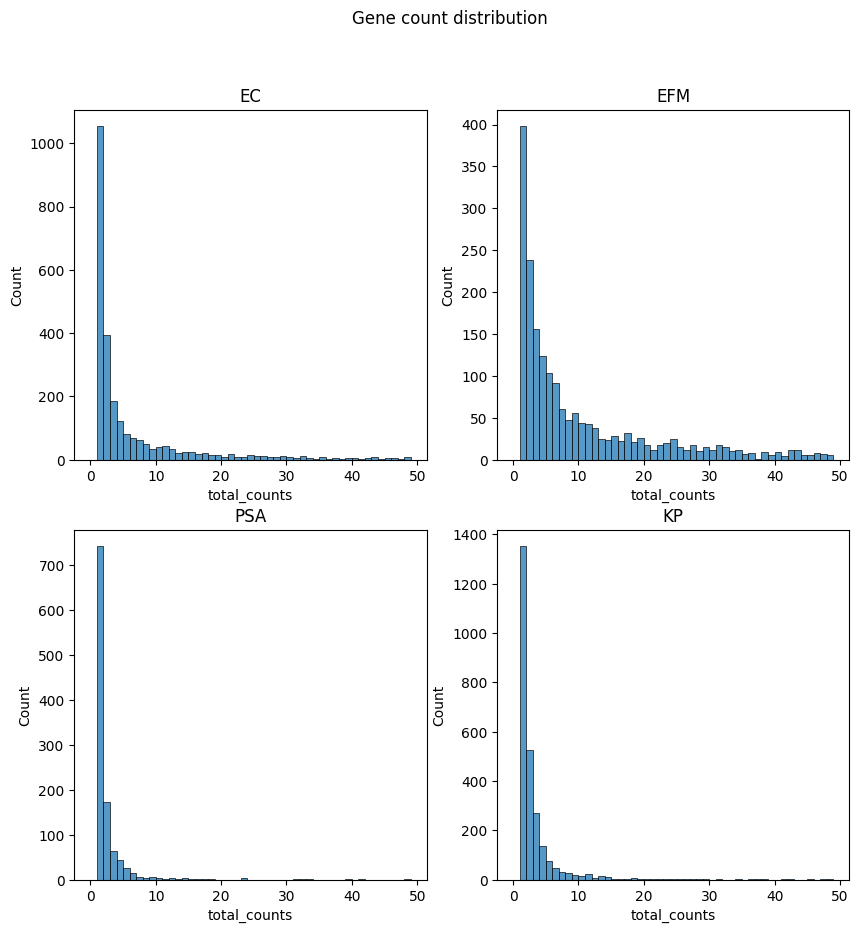

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(data_gex_ec.var["total_counts"], bins=np.arange(50), ax=axes[0, 0])
sns.histplot(data_gex_efm.var["total_counts"], bins=np.arange(50), ax=axes[0, 1])
sns.histplot(data_gex_psa.var["total_counts"], bins=np.arange(50), ax=axes[1, 0])
sns.histplot(data_gex_kp.var["total_counts"], bins=np.arange(50), ax=axes[1, 1])

axes[0,0].set_title("EC")
axes[0,1].set_title("EFM")
axes[1,0].set_title("PSA")
axes[1,1].set_title("KP")
fig.suptitle("Gene count distribution")

In [23]:
print("Number of genes in EC  found in at least 5% of the cells: ", (1 - data_gex_ec.var["pct_dropout_by_counts"].sort_values().values / 100 > 0.05).sum())
print("Number of genes in EFM found in at least 5% of the cells: ", (1 - data_gex_efm.var["pct_dropout_by_counts"].sort_values().values / 100 > 0.05).sum())
print("Number of genes in PSA found in at least 5% of the cells: ", (1 - data_gex_psa.var["pct_dropout_by_counts"].sort_values().values / 100 > 0.05).sum())
print("Number of genes in KP  found in at least 5% of the cells: ", (1 - data_gex_kp.var["pct_dropout_by_counts"].sort_values().values / 100 > 0.05).sum())
print()
print("Number of genes in EC  found in at least 5% of the cells: ", (1 - data_gex_ec.var["pct_dropout_by_counts"].sort_values().values / 100 > 0.01).sum())
print("Number of genes in EFM found in at least 5% of the cells: ", (1 - data_gex_efm.var["pct_dropout_by_counts"].sort_values().values / 100 > 0.01).sum())
print("Number of genes in PSA found in at least 5% of the cells: ", (1 - data_gex_psa.var["pct_dropout_by_counts"].sort_values().values / 100 > 0.01).sum())
print("Number of genes in KP  found in at least 5% of the cells: ", (1 - data_gex_kp.var["pct_dropout_by_counts"].sort_values().values / 100 > 0.01).sum())

Number of genes in EC  found in at least 5% of the cells:  52
Number of genes in EFM found in at least 5% of the cells:  58
Number of genes in PSA found in at least 5% of the cells:  28
Number of genes in KP  found in at least 5% of the cells:  41

Number of genes in EC  found in at least 5% of the cells:  245
Number of genes in EFM found in at least 5% of the cells:  286
Number of genes in PSA found in at least 5% of the cells:  353
Number of genes in KP  found in at least 5% of the cells:  195


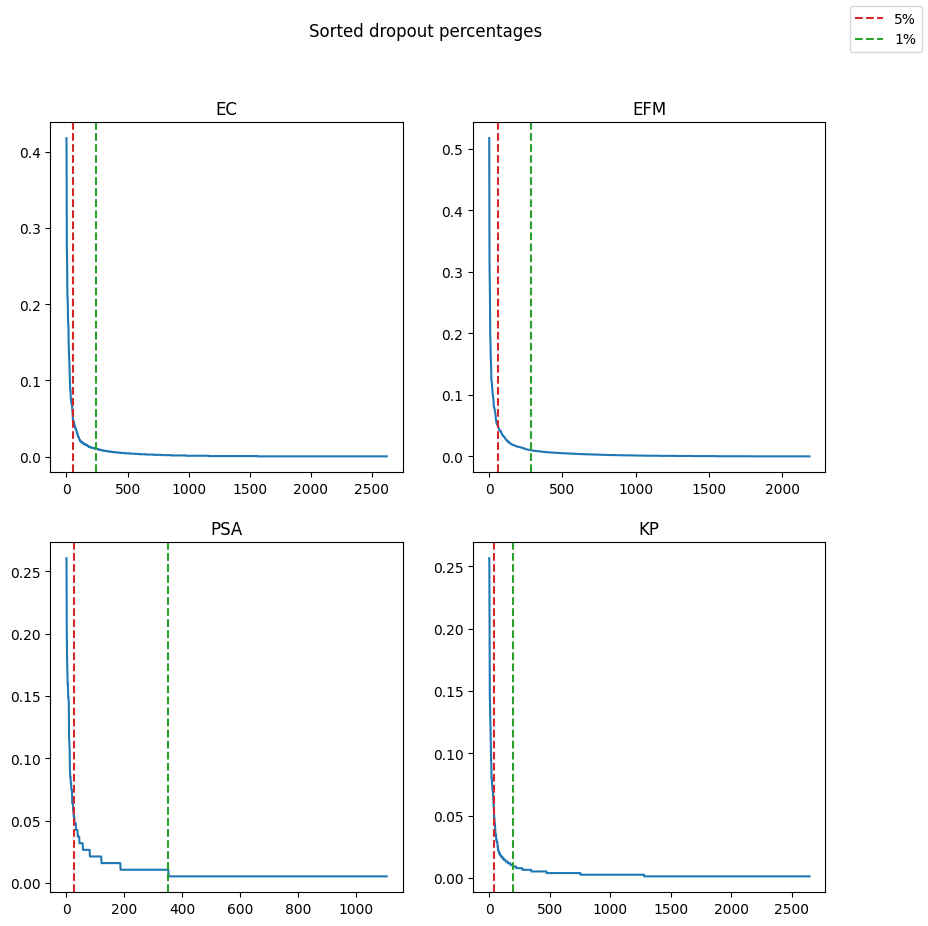

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.lineplot(1-data_gex_ec.var["pct_dropout_by_counts"].sort_values().values / 100, color="C0", ax=axes[0,0])
axes[0,0].axvline(x=51, color="C3", ls="--", label="5%")
#axes[0,0].axhline(y=0.05, color="C3", ls="--", label="5%")
axes[0,0].axvline(x=244, color="C2", ls="--", label="1%")
#axes[0,0].axhline(y=0.01, color="C2", ls="--", label="1%")

sns.lineplot(1-data_gex_efm.var["pct_dropout_by_counts"].sort_values().values / 100, color="C0", ax=axes[0,1])
axes[0,1].axvline(x=57, color="C3", ls="--")
#axes[0,1].axhline(y=0.05, color="C3", ls="--")
axes[0,1].axvline(x=285, color="C2", ls="--",)

sns.lineplot(1-data_gex_psa.var["pct_dropout_by_counts"].sort_values().values / 100, color="C0", ax=axes[1,0])
axes[1,0].axvline(x=27, color="C3", ls="--")
#axes[1,0].axhline(y=0.05, color="C3", ls="--")
axes[1,0].axvline(x=352, color="C2", ls="--",)

sns.lineplot(1-data_gex_kp.var["pct_dropout_by_counts"].sort_values().values / 100, color="C0", ax=axes[1,1])
axes[1,1].axvline(x=40, color="C3", ls="--")
#axes[1,1].axhline(y=0.05, color="C3", ls="--")
axes[1,1].axvline(x=194, color="C2", ls="--",)

axes[0,0].set_title("EC")
axes[0,1].set_title("EFM")
axes[1,0].set_title("PSA")
axes[1,1].set_title("KP")
fig.suptitle("Sorted dropout percentages")
fig.legend()

In [36]:
filter_top5 = data_gex_ec.var.pct_dropout_by_counts <= 95
filter_top1 = data_gex_ec.var.pct_dropout_by_counts <= 99

In [70]:
ec_top5 = data_gex_ec[:, filter_top5].copy()
ec_top1 = data_gex_ec[:, filter_top1].copy()

sc.pp.calculate_qc_metrics(ec_top5, var_type="genes", qc_vars=["rRNA"], percent_top=None, log1p=True, inplace=True)
sc.pp.calculate_qc_metrics(ec_top1, var_type="genes", qc_vars=["rRNA"], percent_top=None, log1p=True, inplace=True)

print(ec_top5.shape)
print(ec_top1.shape)

(2507, 52)
(2507, 245)


### Removal of doublets and noise
Most of the cells express not more than ~250 genes per cell and are probably doublets, so they are removed. \
In a second step we remove all cells that have less than 15 counts, since they dont contain significant information and this was performed in the bacdrop paper as well. \

In [16]:
'''sc.pp.calculate_qc_metrics(data_gex, var_type="genes", percent_top=None, log1p=False, inplace=True)

sc.pp.calculate_qc_metrics(data_gex_ec, var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_efm, var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_psa, var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_kp, var_type="genes", percent_top=None, log1p=False, inplace=True)'''

In [17]:
'''print("EC")
print('Original data shape:\t\t', data_gex_ec.shape)
sc.pp.filter_cells(data_gex_ec, max_counts=250)
print('Shape after doublet removal:\t', data_gex_ec.shape)
print("EFM")
print('Original data shape:\t\t', data_gex_efm.shape)
sc.pp.filter_cells(data_gex_efm, max_counts=250)
print('Shape after doublet removal:\t', data_gex_efm.shape)
print("PSA")
print('Original data shape:\t\t', data_gex_psa.shape)
sc.pp.filter_cells(data_gex_psa, max_counts=250)
print('Shape after doublet removal:\t', data_gex_psa.shape)
print("KP")
print('Original data shape:\t\t', data_gex_kp.shape)
sc.pp.filter_cells(data_gex_kp, max_counts=250)
print('Shape after doublet removal:\t', data_gex_kp.shape)'''

EC
Original data shape:		 (9654, 3642)
Shape after doublet removal:	 (9639, 3642)
EFM
Original data shape:		 (9975, 2350)
Shape after doublet removal:	 (9963, 2350)
PSA
Original data shape:		 (8192, 3478)
Shape after doublet removal:	 (8192, 3478)
KP
Original data shape:		 (8648, 4539)
Shape after doublet removal:	 (8647, 4539)


Text(0.5, 1.0, 'Distribution of counts')

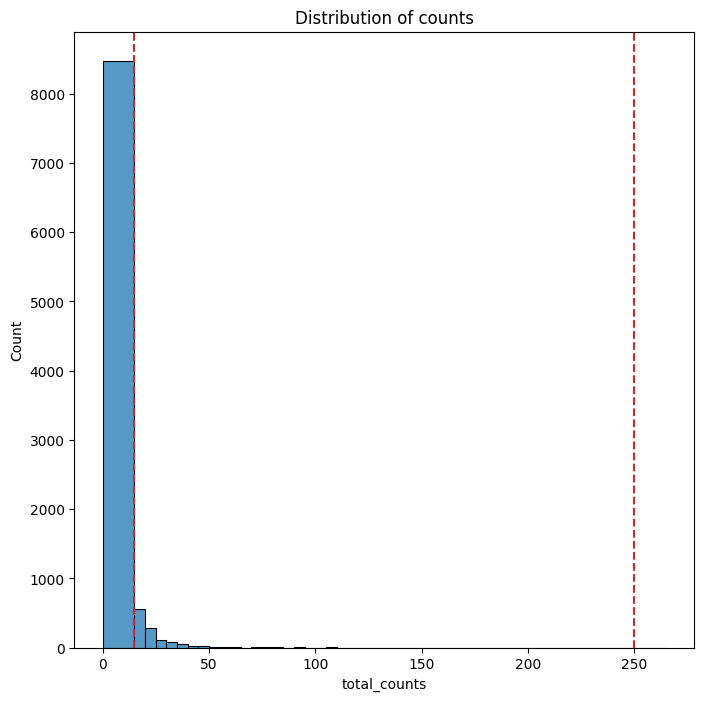

In [18]:
'''bins = np.arange(15, 255, 5)
bins = np.append(bins, 265)
bins = np.insert(bins, 0, 0)

plt.figure(figsize=(8,8))
sns.histplot(data_gex_ec.obs.total_counts, bins=bins)
#plt.yscale("log")
plt.axvline(x=15, color="C3", ls="--")
plt.axvline(x=250, color="C3", ls="--")
plt.title("Distribution of counts")'''

In [19]:
print("EC")
print('Original data shape:\t\t', data_gex_ec.shape)
sc.pp.filter_cells(data_gex_ec, min_counts=10)
sc.pp.filter_genes(data_gex_ec, min_counts=1)
sc.pp.filter_cells(data_gex_ec, min_counts=1)
print('Shape after noise removal:\t', data_gex_ec.shape)
print("EFM")
print('Original data shape:\t\t', data_gex_efm.shape)
sc.pp.filter_cells(data_gex_efm, min_counts=10)
sc.pp.filter_genes(data_gex_efm, min_counts=1)
sc.pp.filter_cells(data_gex_efm, min_counts=1)
print('Shape after noise removal:\t', data_gex_efm.shape)
print("PSA")
print('Original data shape:\t\t', data_gex_psa.shape)
sc.pp.filter_cells(data_gex_psa, min_counts=10)
sc.pp.filter_genes(data_gex_psa, min_counts=1)
sc.pp.filter_cells(data_gex_psa, min_counts=1)
print('Shape after noise removal:\t', data_gex_psa.shape)
print("KP")
print('Original data shape:\t\t', data_gex_kp.shape)
sc.pp.filter_cells(data_gex_kp, min_counts=10)
sc.pp.filter_genes(data_gex_kp, min_counts=1)
sc.pp.filter_cells(data_gex_kp, min_counts=1)
print('Shape after noise removal:\t', data_gex_kp.shape)

EC
Original data shape:		 (9639, 3642)
Shape after noise removal:	 (2524, 2662)
EFM
Original data shape:		 (9963, 2350)
Shape after noise removal:	 (4804, 2220)
PSA
Original data shape:		 (8192, 3478)
Shape after noise removal:	 (251, 1860)
KP
Original data shape:		 (8647, 4539)
Shape after noise removal:	 (850, 3113)


In [56]:
sc.pp.calculate_qc_metrics(data_gex, var_type="genes", percent_top=None, log1p=False, inplace=True)

sc.pp.calculate_qc_metrics(data_gex_ec, var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_efm, var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_psa, var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(data_gex_kp, var_type="genes", percent_top=None, log1p=False, inplace=True)

## Example of preprocessing on E. Coli
The other 3 strains can be found below

### Splitting into 3 datasets per strain
For each strain we now split into 3 different datasets based on different gene abundance levels:
1) All genes
2) High abundance genes (>=10 apperances)
3) Low abundance genes (<10 apperances)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


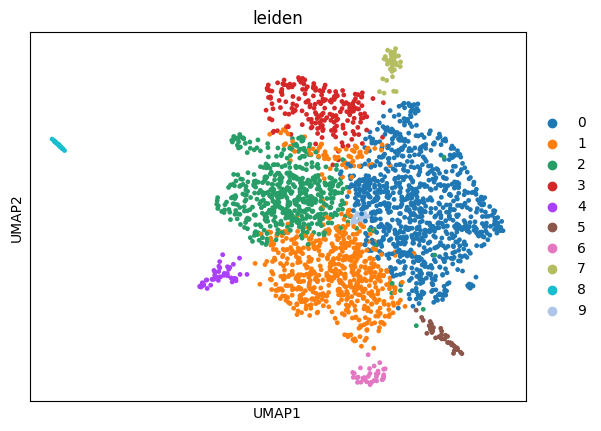

In [91]:
sc.pp.neighbors(data_gex_ec, n_neighbors=15)
sc.tl.leiden(data_gex_ec, resolution=0.3, key_added="leiden")
sc.tl.umap(data_gex_ec)
sc.pl.umap(data_gex_ec, color=["leiden"])

In [95]:
data_gex_ec[data_gex_ec.obs["leiden"] == "8"]

View of AnnData object with n_obs × n_vars = 21 × 2662
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts', 'leiden'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [58]:
abundance_filter, _ = sc.pp.filter_genes(data_gex_ec, min_cells=10, inplace=False)
rRNA_filter = data_gex_ec.var["rRNA"].values 

In [59]:
ec_mudata = md.MuData({"all_genes": data_gex_ec.copy(), 
                       "high_abundance_genes": data_gex_ec[:, abundance_filter].copy(), 
                       "low_abundance_genes":  data_gex_ec[:, ~abundance_filter].copy(),
                       "rRNA_genes": data_gex_ec[:, rRNA_filter].copy(),
                       "mRNA_genes": data_gex_ec[:, ~rRNA_filter].copy()
                       })

sc.pp.calculate_qc_metrics(ec_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(ec_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(ec_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(ec_mudata["rRNA_genes"],           var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(ec_mudata["mRNA_genes"],           var_type="genes", percent_top=None, log1p=False, inplace=True)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


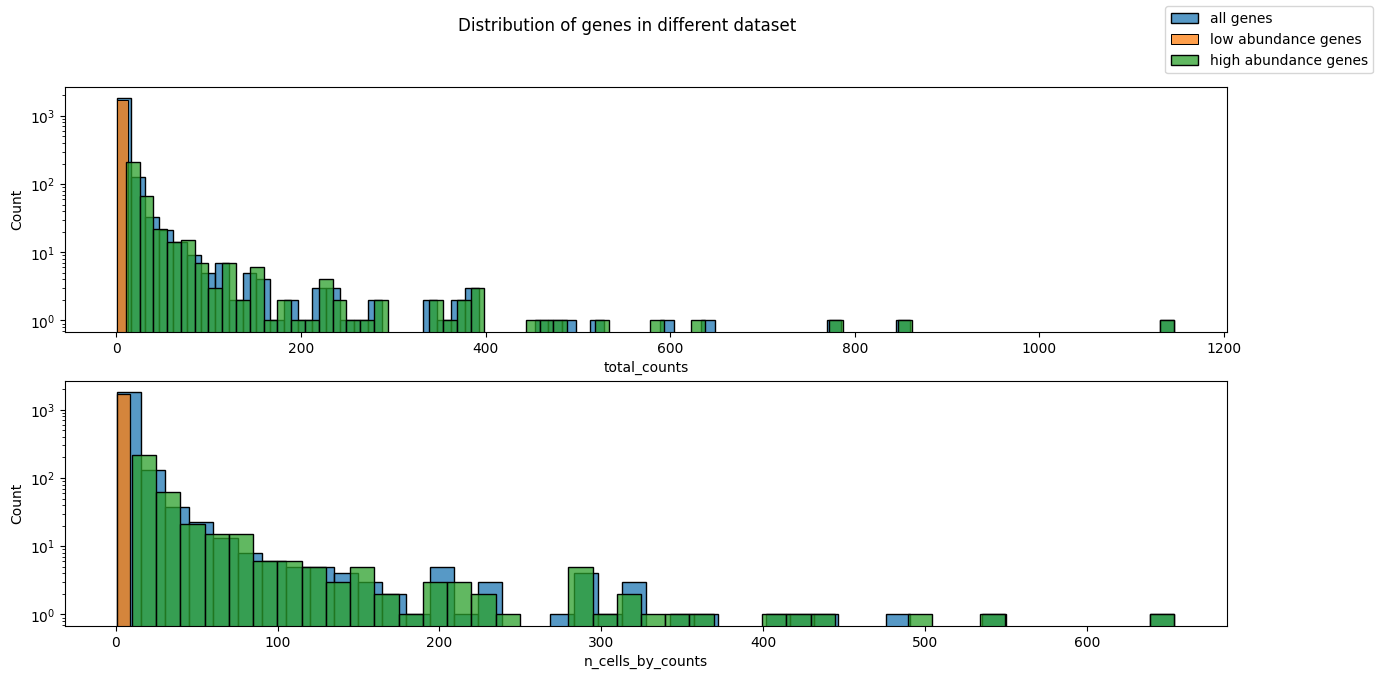

In [64]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(ec_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(ec_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(ec_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(ec_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(ec_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(ec_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

#axes[0].set_title("Total counts for genes")
#axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

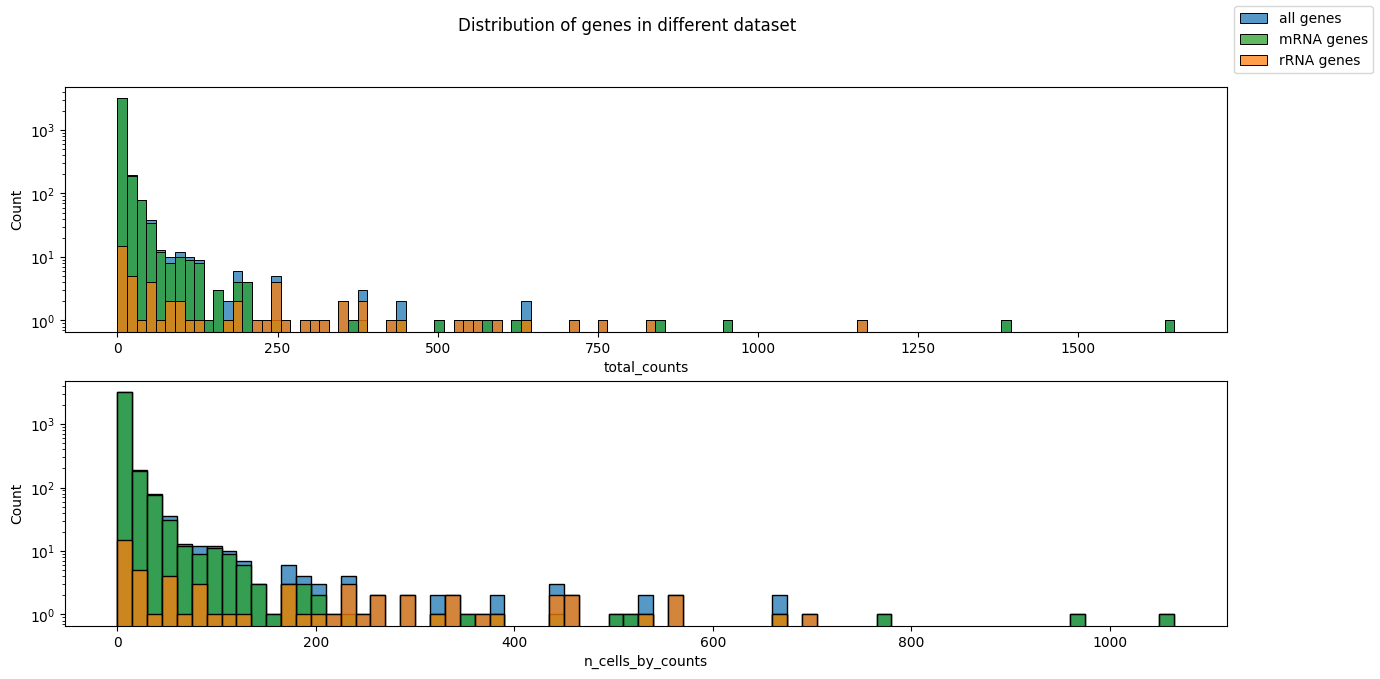

In [65]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(ec_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(ec_mudata["mRNA_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="mRNA genes", ax=axes[0])
sns.histplot(ec_mudata["rRNA_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="rRNA genes", ax=axes[0])

sns.histplot(ec_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(ec_mudata["mRNA_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])
sns.histplot(ec_mudata["rRNA_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

#axes[0].set_title("Total counts for genes")
#axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

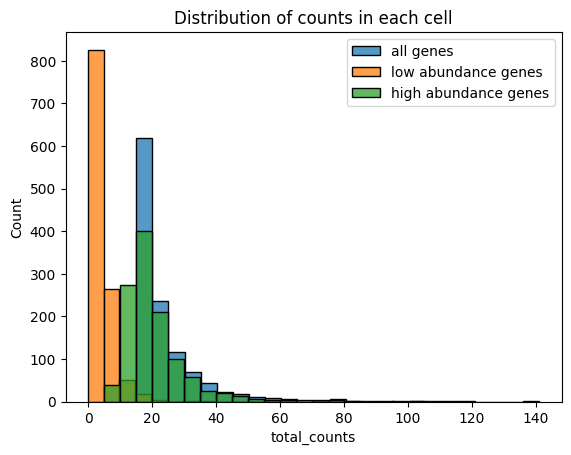

In [65]:
sns.histplot(ec_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
sns.histplot(ec_mudata["low_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C1", label="low abundance genes")
sns.histplot(ec_mudata["high_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C2", label="high abundance genes")
plt.title("Distribution of counts in each cell")
plt.legend()

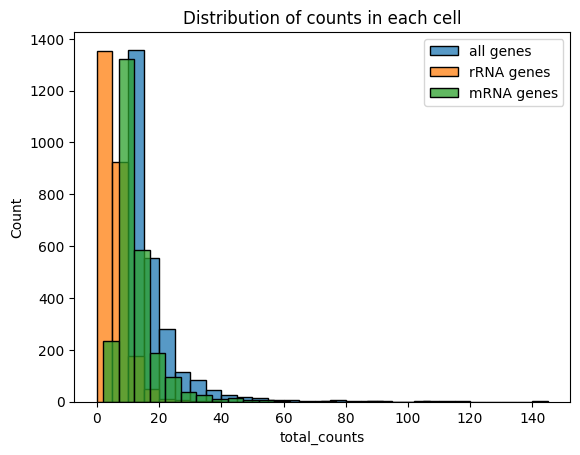

In [63]:
sns.histplot(ec_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
sns.histplot(ec_mudata["rRNA_genes"].obs["total_counts"], binwidth=5, kde=False, color="C1", label="rRNA genes")
sns.histplot(ec_mudata["mRNA_genes"].obs["total_counts"], binwidth=5, kde=False, color="C2", label="mRNA genes")
plt.title("Distribution of counts in each cell")
plt.legend()

In [66]:
agx, agy = ec_mudata["all_genes"].obs["total_counts"], ec_mudata["all_genes"].obs["n_genes_by_counts"] 
lagx, lagy = ec_mudata["low_abundance_genes"].obs["total_counts"], ec_mudata["low_abundance_genes"].obs["n_genes_by_counts"]
hagx, hagy =  ec_mudata["high_abundance_genes"].obs["total_counts"], ec_mudata["high_abundance_genes"].obs["n_genes_by_counts"]

_, _, r_value, _, _ = stats.linregress(agx, agy)
ag_r_squared = r_value ** 2

_, _, r_value, _, _ = stats.linregress(lagx, lagy)
lag_r_squared = r_value ** 2

_, _, r_value, _, _ = stats.linregress(hagx, hagy)
hag_r_squared = r_value ** 2

print(ag_r_squared, lag_r_squared, hag_r_squared)

0.956819539614272 0.9946645710405676 0.9416966967036964


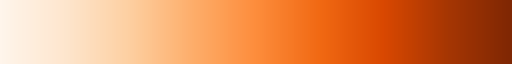

In [67]:
cmap = matplotlib.colormaps.get_cmap("Oranges")
cmap

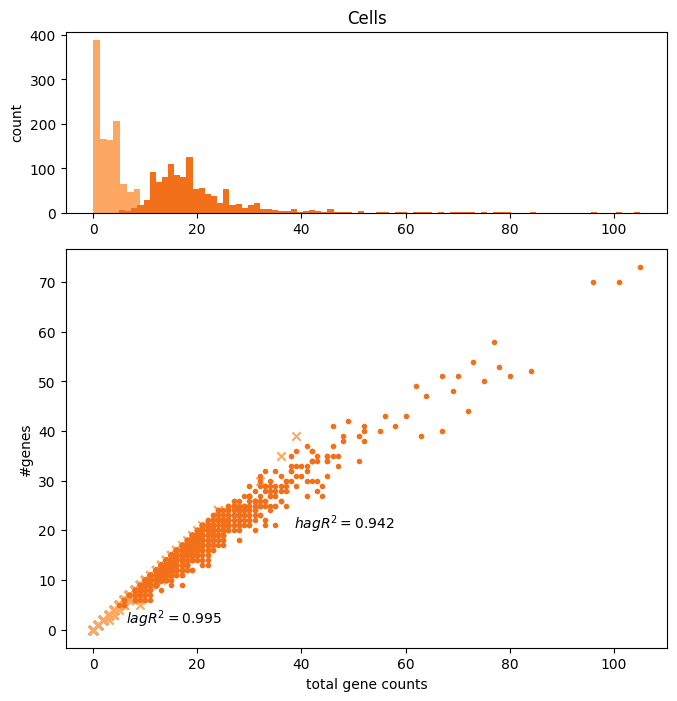

In [68]:
lim  = min(ec_mudata["all_genes"].obs["total_counts"].max(), ec_mudata["all_genes"].obs["n_genes_by_counts"].max())
line = [0, lim]

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 3)

ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2])

ax_main.scatter(data=ec_mudata["low_abundance_genes"].obs, x="total_counts" , y="n_genes_by_counts", marker='x', color=cmap(0.4))
ax_main.scatter(data=ec_mudata["high_abundance_genes"].obs, x="total_counts" , y="n_genes_by_counts", marker='.', color=cmap(0.6))

#ax_main.plot(line, line, color='red', label='x=y', linestyle="--")
ax_main.set(xlabel="total gene counts", ylabel="#genes")
ax_main.text(0.1, 0.06, f'$lag R^2 = {lag_r_squared:.3f}$', fontsize=10, transform=ax_main.transAxes)
ax_main.text(0.38, 0.3, f'$hag R^2 = {hag_r_squared:.3f}$', fontsize=10, transform=ax_main.transAxes)

bins = np.arange(0, lim, 100)

ax_xDist.hist(ec_mudata["low_abundance_genes"].obs["total_counts"], bins=30, align='mid', color=cmap(0.4))
ax_xDist.hist(ec_mudata["high_abundance_genes"].obs["total_counts"], bins=85, align='mid', color=cmap(0.6))
ax_xDist.set(ylabel='count')
#ax_xDist.set_yscale('log')
#ax_xDist.set_xlim(0, 10000)
plt.title("Cells")
plt.show()

In [69]:
agx, agy = ec_mudata["all_genes"].var["total_counts"], ec_mudata["all_genes"].var["n_cells_by_counts"] 
lagx, lagy = ec_mudata["low_abundance_genes"].var["total_counts"], ec_mudata["low_abundance_genes"].var["n_cells_by_counts"]
hagx, hagy =  ec_mudata["high_abundance_genes"].var["total_counts"], ec_mudata["high_abundance_genes"].var["n_cells_by_counts"]

_, _, r_value, _, _ = stats.linregress(agx, agy)
ag_r_squared = r_value ** 2

_, _, r_value, _, _ = stats.linregress(lagx, lagy)
lag_r_squared = r_value ** 2

_, _, r_value, _, _ = stats.linregress(hagx, hagy)
hag_r_squared = r_value ** 2

print(ag_r_squared, lag_r_squared, hag_r_squared)

0.9684709445528675 0.9874837923280326 0.9674563832271865


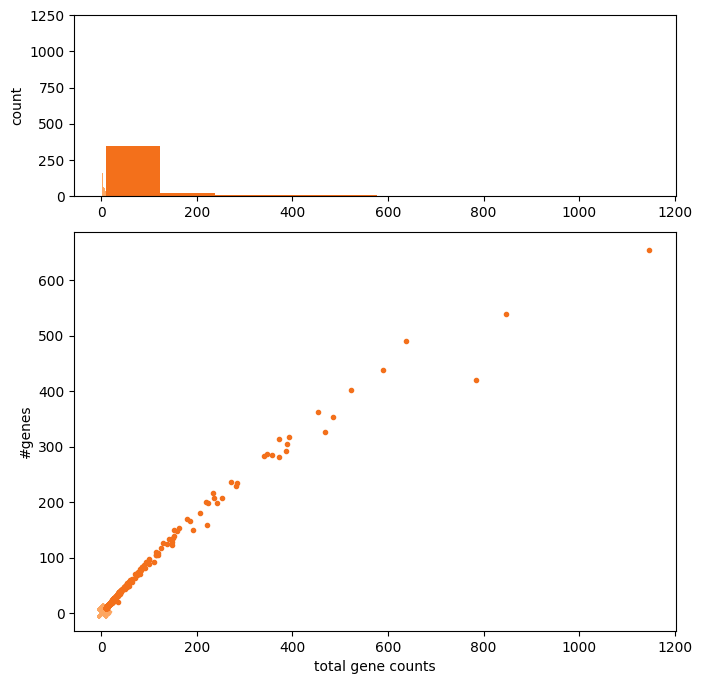

In [70]:
lim  = min(ec_mudata["all_genes"].var["total_counts"].max(), ec_mudata["all_genes"].var["n_cells_by_counts"].max())
line = [0, lim]

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 3)

ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2])

ax_main.scatter(data=ec_mudata["low_abundance_genes"].var, x="total_counts" , y="n_cells_by_counts", marker='x', color=cmap(0.4))

ax_main.scatter(data=ec_mudata["high_abundance_genes"].var, x="total_counts" , y="n_cells_by_counts", marker='.', color=cmap(0.6))

#ax_main.plot(line, line, color='red', label='x=y', linestyle="--")
ax_main.set(xlabel="total gene counts", ylabel="#genes")
#ax_main.text(0.27, 0.7, f'$R^2 = {r_squared:.3f}$', fontsize=12, transform=ax_main.transAxes)

bins = np.arange(0, lim, 100)

ax_xDist.hist(ec_mudata["low_abundance_genes"].var["total_counts"], align='mid', color=cmap(0.4))
ax_xDist.hist(ec_mudata["high_abundance_genes"].var["total_counts"], align='mid', color=cmap(0.6))
ax_xDist.set(ylabel='count')
#ax_xDist.set_yscale('log')
#ax_xDist.set_xlim(0, 10000)

plt.show()

### Normalization & Variance stabilization

Several normalization methods and VSTs are applied and saved in different layers:
- Log1p normalization
- Scanpy's total sum normalization with target sum being median count
- Square root transformation
- (Scran normalization (https://www.sc-best-practices.org/preprocessing_visualization/normalization.html & https://github.com/sfortma2/scranPY/blob/main/scranPY_tutorial.ipynb) --> Can be found in ./scran.ipynb notebook)

In [66]:
for i in ec_mudata.mod:
    ec_mudata[i].layers["raw_counts"]  = ec_mudata[i].X
    ec_mudata[i].layers["log1p"]       = sc.pp.log1p(ec_mudata[i], copy=True).X
    ec_mudata[i].layers["sqrt_counts"] = np.sqrt(ec_mudata[i].X)
    ec_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(ec_mudata[i], target_sum=None, inplace=False)['X']
ec_mudata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\preprocessing\_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


MuData object with n_obs × n_vars = 2524 × 10926
  5 modalities
    all_genes:	2524 x 3642
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	2524 x 571
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	2524 x 3071
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    rRNA_genes:	2524 x 60
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    mRNA_genes:	2524 x 3582
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'E. Coli All Genes Normalization & VST')

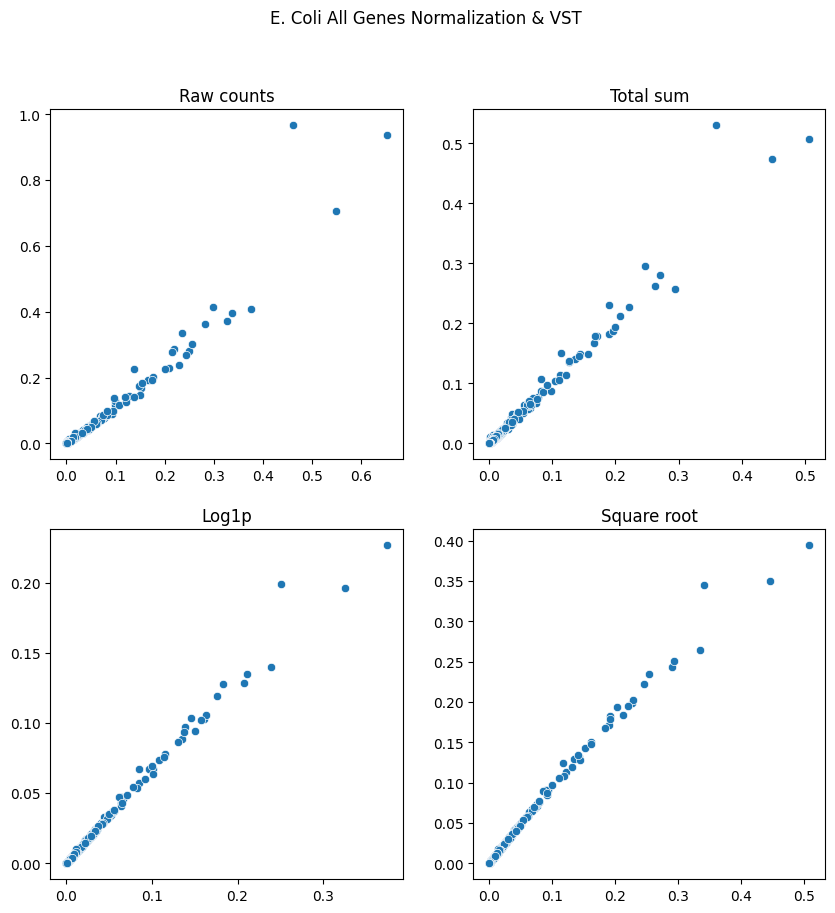

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("E. Coli All Genes Normalization & VST")

Text(0.5, 0.98, 'E. Coli Low And High Abundance Genes Normalization & VST')

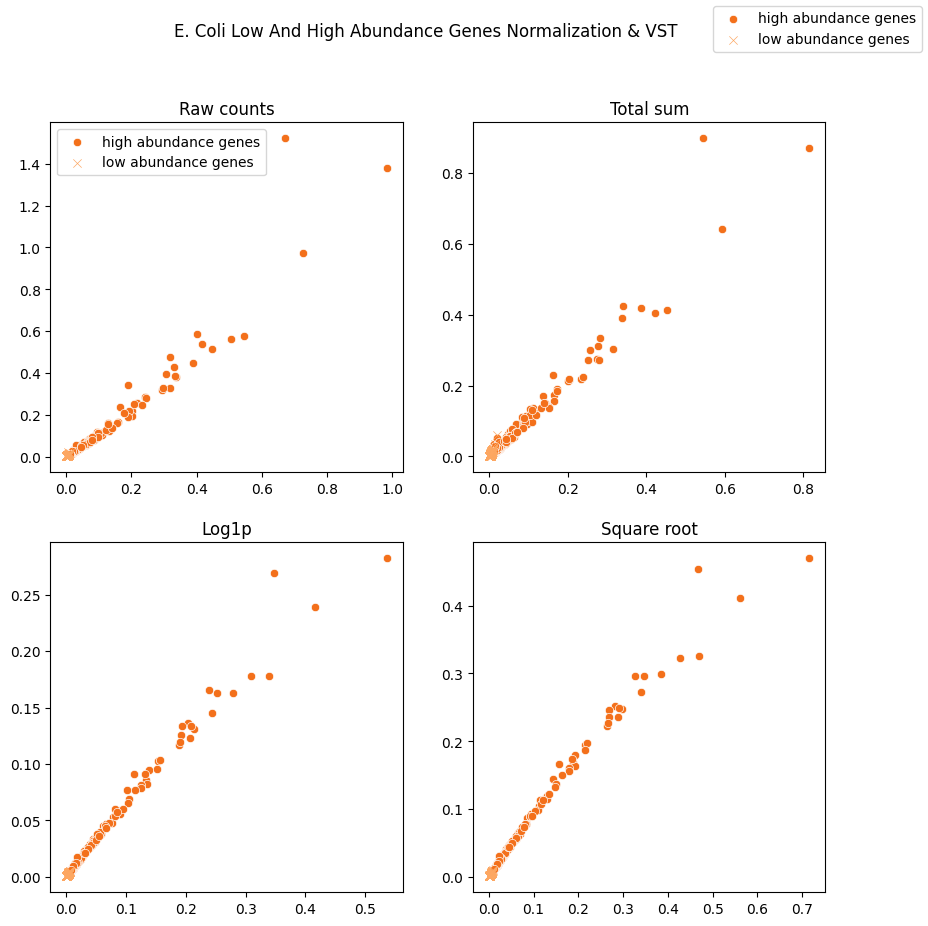

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].X.A, axis=0), 
                color=cmap(0.6), label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color=cmap(0.6), ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color=cmap(0.6), ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color=cmap(0.6), ax=axes[1][1])


sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                color=cmap(0.4), marker="x", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color=cmap(0.4), marker="x", ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color=cmap(0.4), marker="x", ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color=cmap(0.4), marker="x", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
#handles, labels = axes.get_legend_handles_labels()
fig.legend(loc='outside upper right')
fig.suptitle("E. Coli Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'E. Coli Low Abundance Genes Normalization & VST')

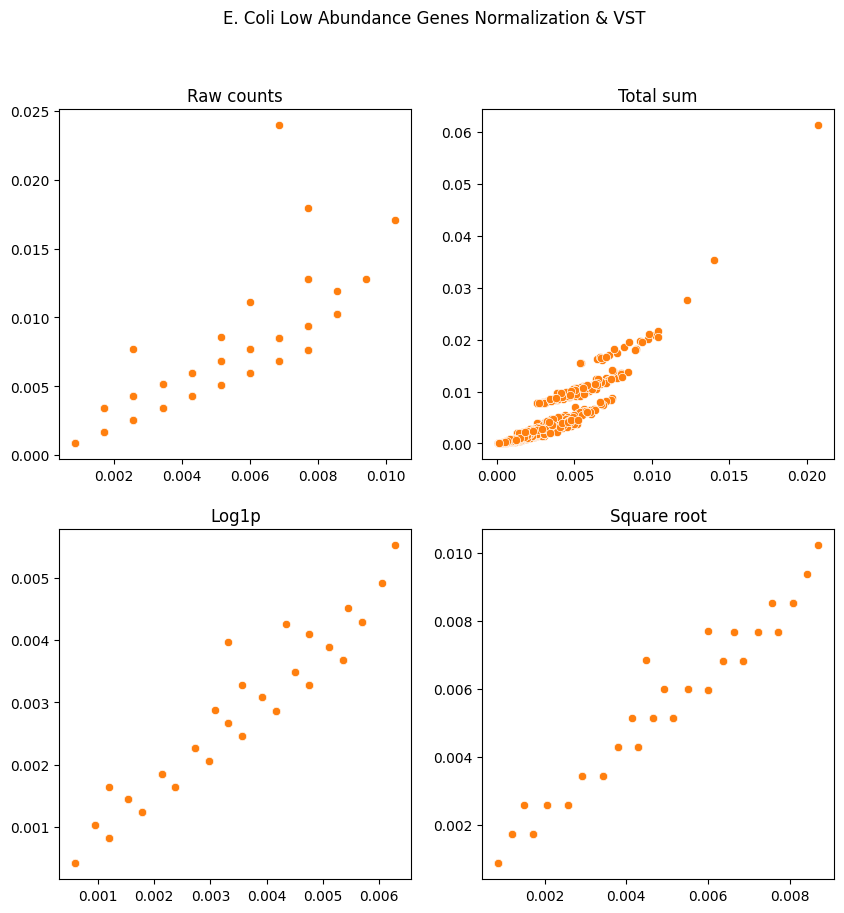

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("E. Coli Low Abundance Genes Normalization & VST")

In [75]:
print(1 - calc_sparsity(ec_mudata["all_genes"].X.A))
print(1 - calc_sparsity(ec_mudata["low_abundance_genes"].X.A))
print(1 - calc_sparsity(ec_mudata["high_abundance_genes"].X.A))

0.988651255930397
0.997908675844756
0.9476267723305898


## Efm

In [70]:
abundance_filter, _ = sc.pp.filter_genes(data_gex_efm, min_cells=10, inplace=False)
rRNA_filter = data_gex_efm.var["rRNA"].values

In [71]:
efm_mudata = md.MuData({"all_genes": data_gex_efm.copy(), 
                       "high_abundance_genes": data_gex_efm[:, abundance_filter].copy(), 
                       "low_abundance_genes":  data_gex_efm[:, ~abundance_filter].copy(),
                       "rRNA_genes": data_gex_efm[:, rRNA_filter].copy(),
                       "mRNA_genes": data_gex_efm[:, ~rRNA_filter].copy()
                       })

sc.pp.calculate_qc_metrics(efm_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(efm_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(efm_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(efm_mudata["rRNA_genes"],           var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(efm_mudata["mRNA_genes"],           var_type="genes", percent_top=None, log1p=False, inplace=True)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


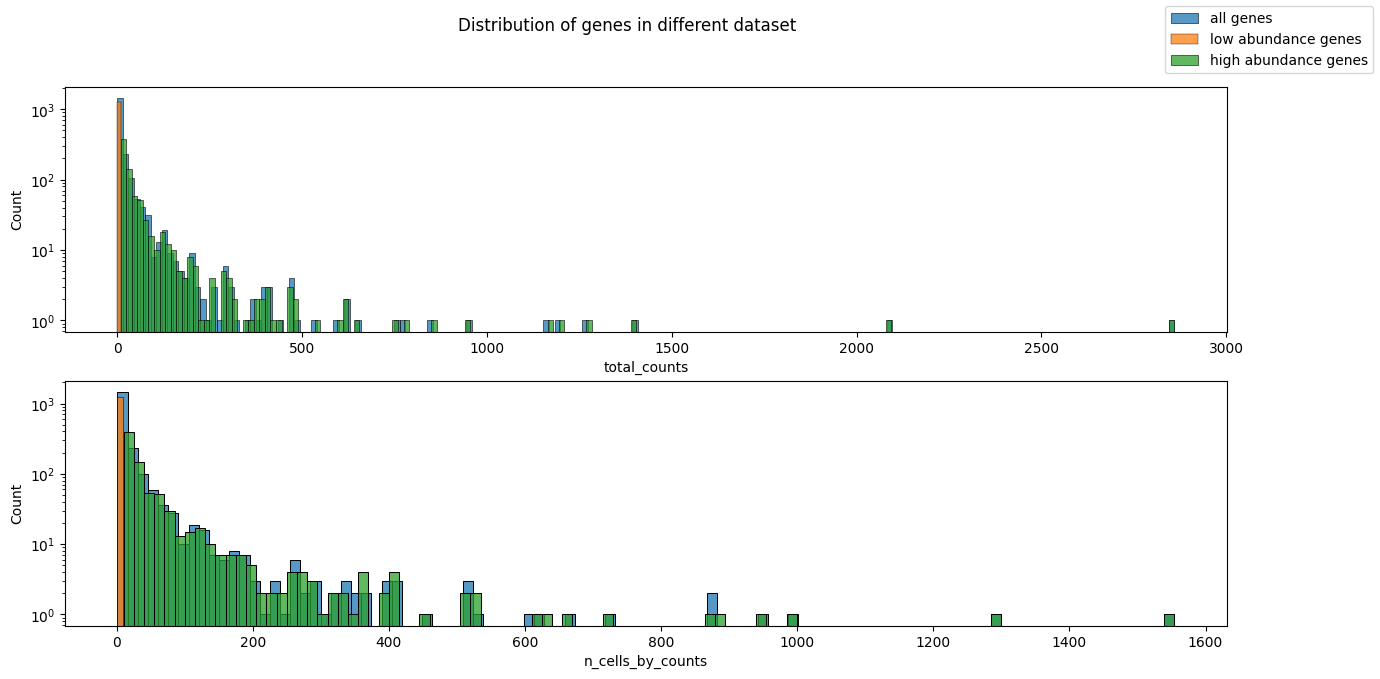

In [78]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(efm_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(efm_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(efm_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(efm_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(efm_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(efm_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

#axes[0].set_title("Total counts for genes")
#axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

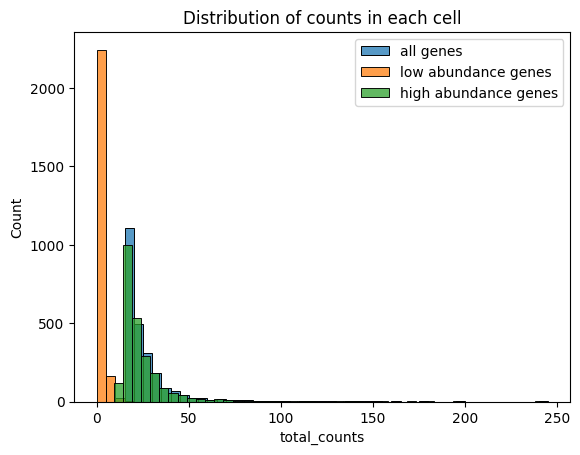

In [79]:
sns.histplot(efm_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
sns.histplot(efm_mudata["low_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C1", label="low abundance genes")
sns.histplot(efm_mudata["high_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C2", label="high abundance genes")
plt.title("Distribution of counts in each cell")
plt.legend()

In [74]:
for i in efm_mudata.mod:
    efm_mudata[i].layers["raw_counts"]  = efm_mudata[i].X
    efm_mudata[i].layers["log1p"]       = sc.pp.log1p(efm_mudata[i], copy=True).X
    efm_mudata[i].layers["sqrt_counts"] = np.sqrt(efm_mudata[i].X)
    efm_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(efm_mudata[i], target_sum=None, inplace=False)['X']
efm_mudata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\preprocessing\_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


MuData object with n_obs × n_vars = 4804 × 7050
  5 modalities
    all_genes:	4804 x 2350
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	4804 x 952
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	4804 x 1398
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    rRNA_genes:	4804 x 60
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    mRNA_genes:	4804 x 2290
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'Efm All Genes Normalization & VST')

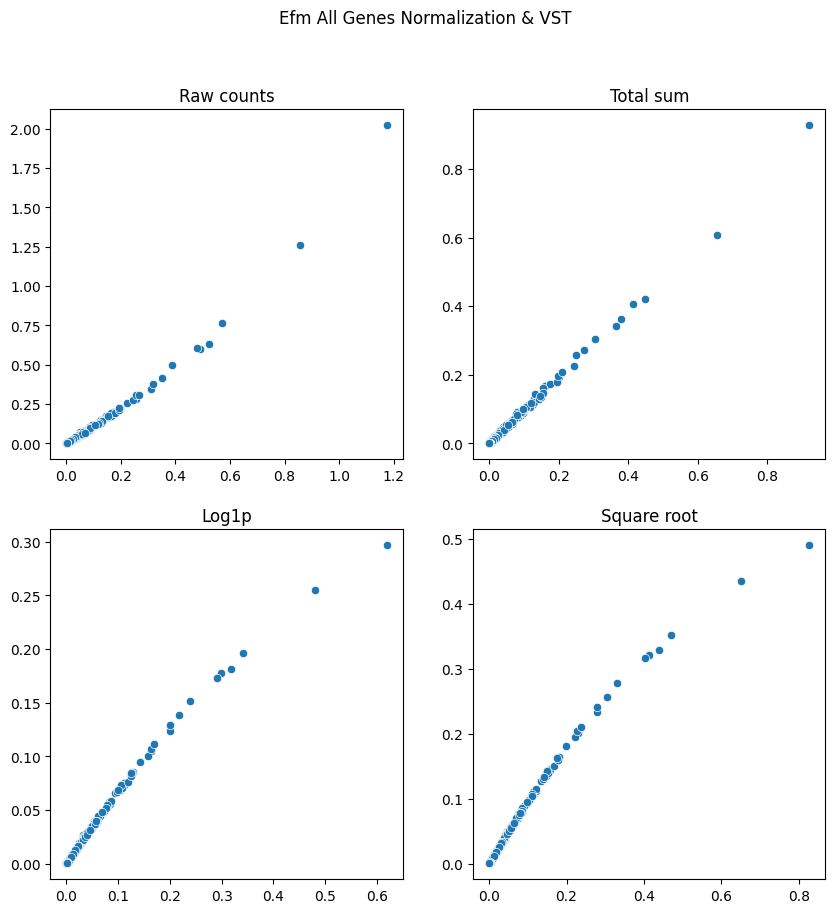

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Efm All Genes Normalization & VST")

Text(0.5, 0.98, 'Efm Low And High Abundance Genes Normalization & VST')

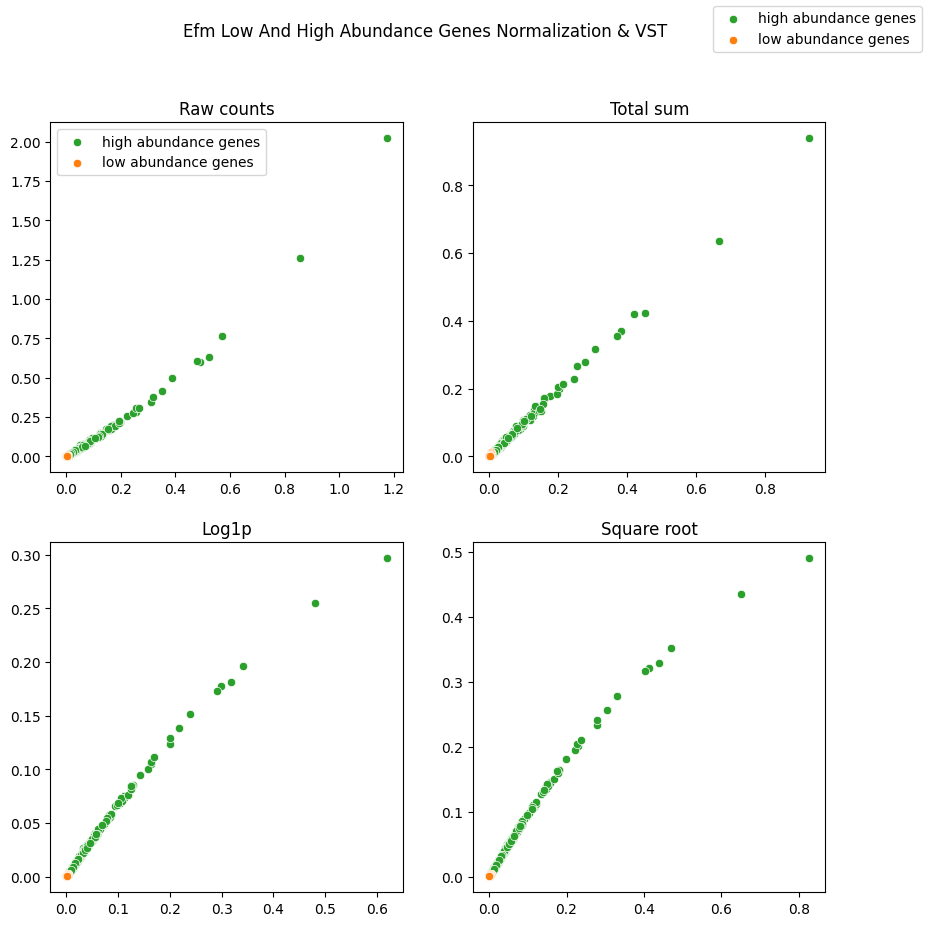

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].X.A, axis=0), 
                color="C2", label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C2", ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C2", ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C2", ax=axes[1][1])


sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.legend()
fig.suptitle("Efm Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'Efm Low Abundance Genes Normalization & VST')

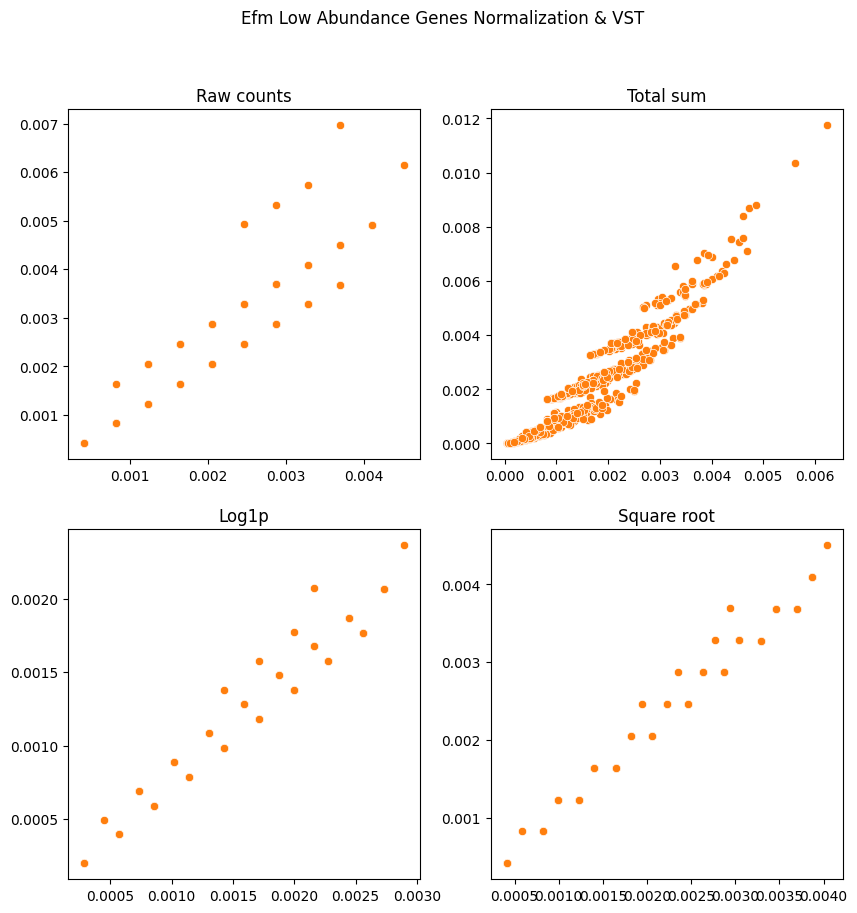

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Efm Low Abundance Genes Normalization & VST")

In [85]:
print(1 - calc_sparsity(efm_mudata["all_genes"].X.A))
print(1 - calc_sparsity(efm_mudata["low_abundance_genes"].X.A))
print(1 - calc_sparsity(efm_mudata["high_abundance_genes"].X.A))

0.9874573506188373
0.9986713334597476
0.9699635373870172


## Psa

In [72]:
abundance_filter, _ = sc.pp.filter_genes(data_gex_psa, min_cells=10, inplace=False)
rRNA_filter = data_gex_psa.var["rRNA"].values

In [73]:
psa_mudata = md.MuData({"all_genes": data_gex_psa.copy(), 
                       "high_abundance_genes": data_gex_psa[:, abundance_filter].copy(), 
                       "low_abundance_genes":  data_gex_psa[:, ~abundance_filter].copy(),
                       "rRNA_genes": data_gex_psa[:, rRNA_filter].copy(),
                       "mRNA_genes": data_gex_psa[:, ~rRNA_filter].copy()
                       })

sc.pp.calculate_qc_metrics(psa_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(psa_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(psa_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(psa_mudata["rRNA_genes"],           var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(psa_mudata["mRNA_genes"],           var_type="genes", percent_top=None, log1p=False, inplace=True)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


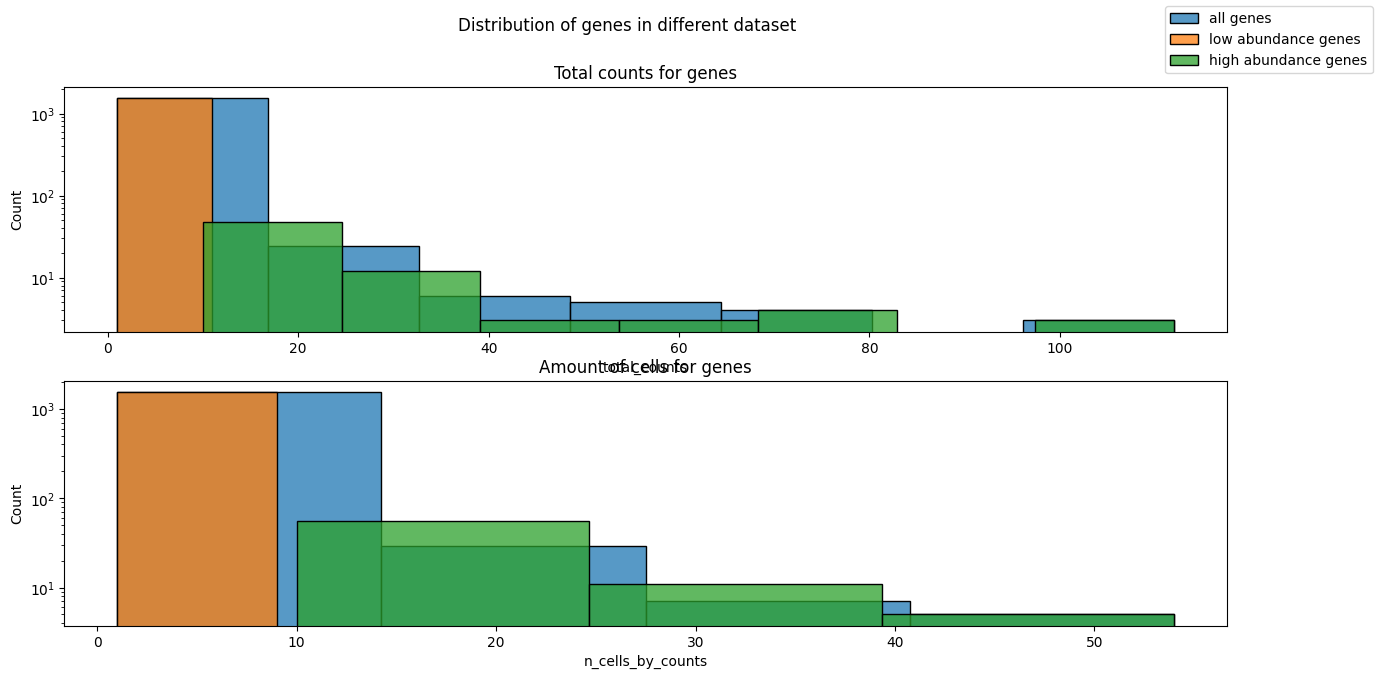

In [88]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(psa_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(psa_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(psa_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(psa_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(psa_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(psa_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

axes[0].set_title("Total counts for genes")
axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

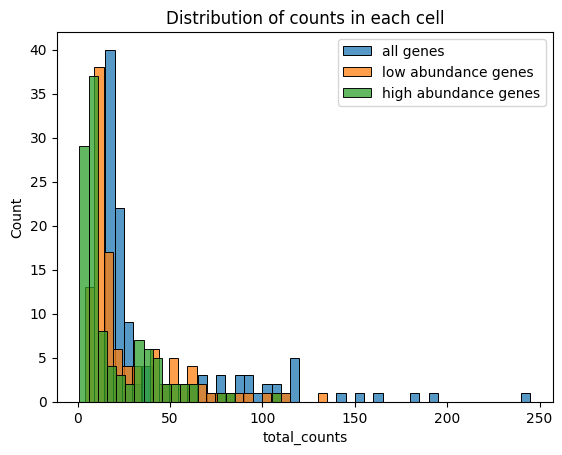

In [89]:
sns.histplot(psa_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
sns.histplot(psa_mudata["low_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C1", label="low abundance genes")
sns.histplot(psa_mudata["high_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C2", label="high abundance genes")
plt.title("Distribution of counts in each cell")
plt.legend()

In [75]:
for i in efm_mudata.mod:
    psa_mudata[i].layers["raw_counts"]  = psa_mudata[i].X
    psa_mudata[i].layers["log1p"]       = sc.pp.log1p(psa_mudata[i], copy=True).X
    psa_mudata[i].layers["sqrt_counts"] = np.sqrt(psa_mudata[i].X)
    psa_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(psa_mudata[i], target_sum=None, inplace=False)['X']
psa_mudata

MuData object with n_obs × n_vars = 251 × 10434
  5 modalities
    all_genes:	251 x 3478
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	251 x 99
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	251 x 3379
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    rRNA_genes:	251 x 58
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    mRNA_genes:	251 x 3420
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'Psa All Genes Normalization & VST')

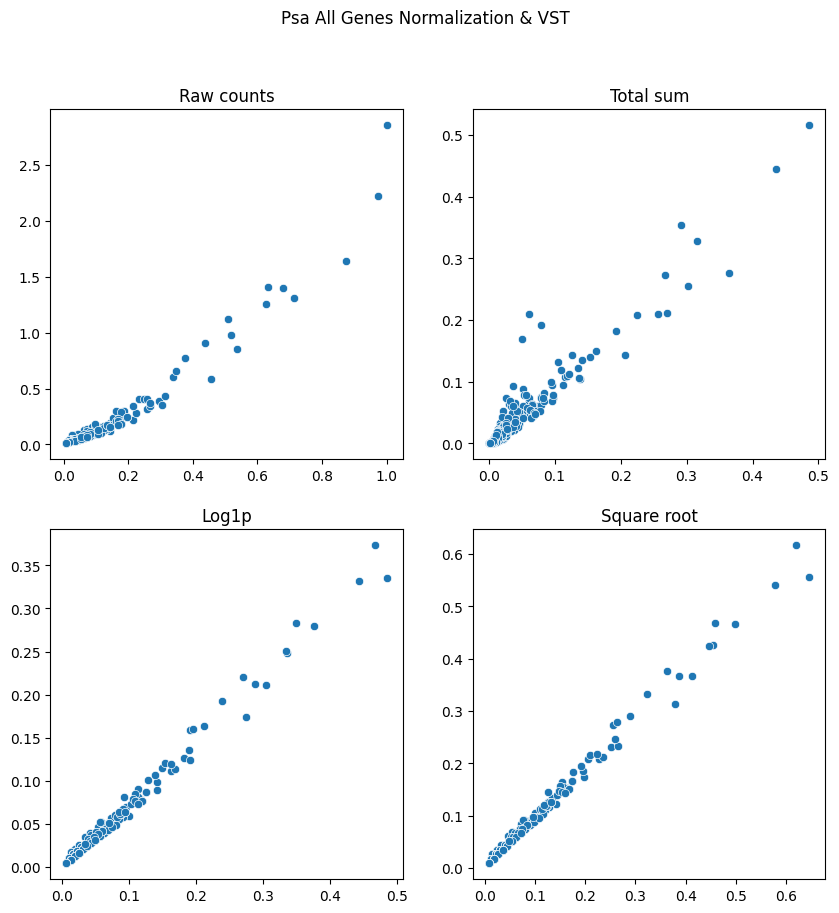

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Psa All Genes Normalization & VST")

Text(0.5, 0.98, 'Psa Low And High Abundance Genes Normalization & VST')

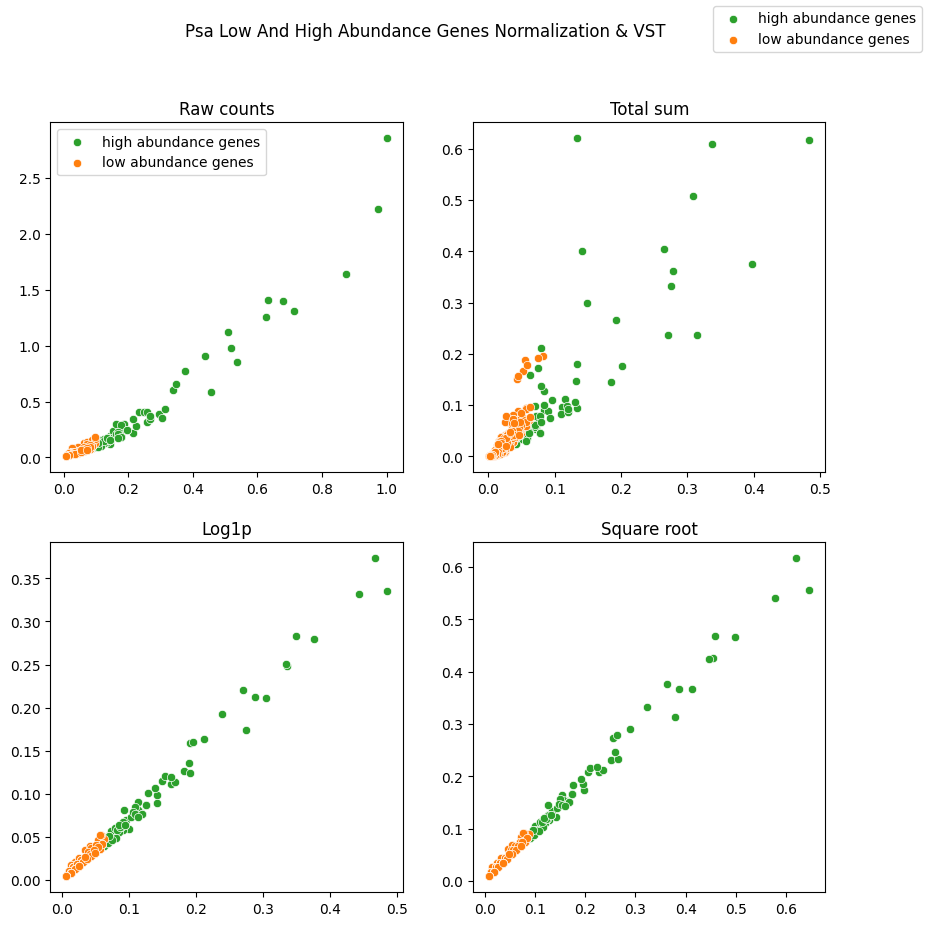

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].X.A, axis=0), 
                color="C2", label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C2", ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C2", ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C2", ax=axes[1][1])


sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.legend()
fig.suptitle("Psa Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'Psa Low Abundance Genes Normalization & VST')

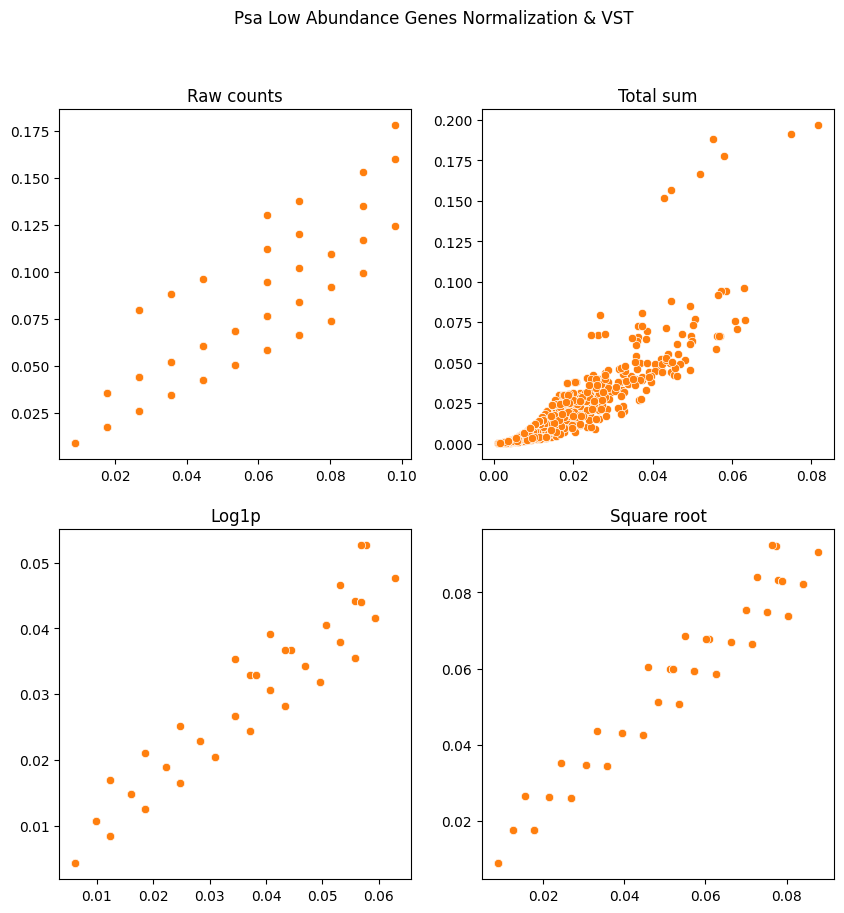

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Psa Low Abundance Genes Normalization & VST")

In [94]:
print(1 - calc_sparsity(psa_mudata["all_genes"].X.A))
print(1 - calc_sparsity(psa_mudata["low_abundance_genes"].X.A))
print(1 - calc_sparsity(psa_mudata["high_abundance_genes"].X.A))

0.9708496921566878
0.9814537980005605
0.7456597222222222


## Kp

In [76]:
abundance_filter, _ = sc.pp.filter_genes(data_gex_kp, min_cells=10, inplace=False)
rRNA_filter = data_gex_kp.var["rRNA"].values

In [77]:
kp_mudata = md.MuData({"all_genes": data_gex_kp.copy(), 
                       "high_abundance_genes": data_gex_kp[:, abundance_filter].copy(), 
                       "low_abundance_genes":  data_gex_kp[:, ~abundance_filter].copy(),
                       "rRNA_genes": data_gex_kp[:, rRNA_filter].copy(),
                       "mRNA_genes": data_gex_kp[:, ~rRNA_filter].copy()
                       })

sc.pp.calculate_qc_metrics(kp_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(kp_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(kp_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(kp_mudata["rRNA_genes"],           var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(kp_mudata["mRNA_genes"],           var_type="genes", percent_top=None, log1p=False, inplace=True)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


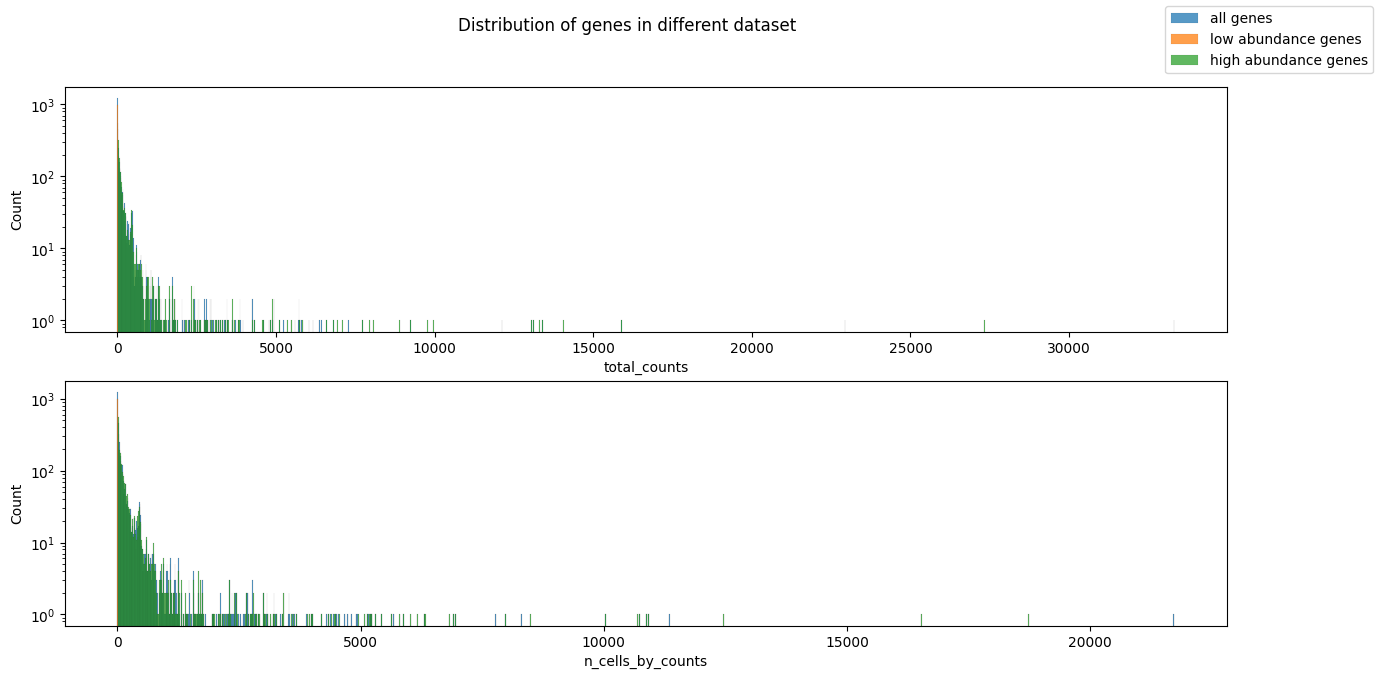

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(mgh_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(mgh_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(mgh_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(mgh_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(mgh_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(mgh_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

#axes[0].set_title("Total counts for genes")
#axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

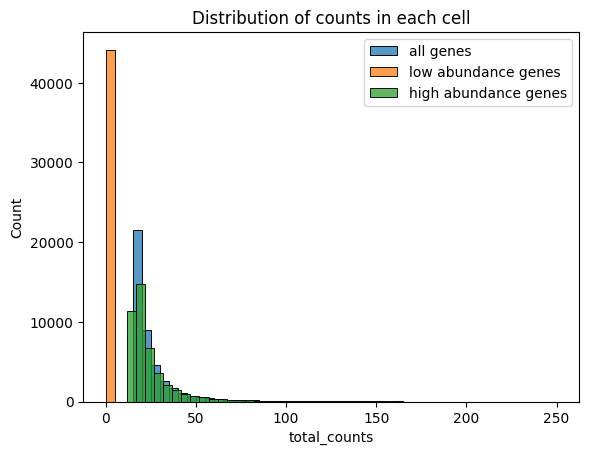

In [44]:
sns.histplot(mgh_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
sns.histplot(mgh_mudata["low_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C1", label="low abundance genes")
sns.histplot(mgh_mudata["high_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C2", label="high abundance genes")
plt.title("Distribution of counts in each cell")
plt.legend()

In [78]:
for i in kp_mudata.mod:
    kp_mudata[i].layers["raw_counts"]  = kp_mudata[i].X
    kp_mudata[i].layers["log1p"]       = sc.pp.log1p(kp_mudata[i], copy=True).X
    kp_mudata[i].layers["sqrt_counts"] = np.sqrt(kp_mudata[i].X)
    kp_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(kp_mudata[i], target_sum=None, inplace=False)['X']
kp_mudata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\preprocessing\_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


MuData object with n_obs × n_vars = 850 × 13617
  5 modalities
    all_genes:	850 x 4539
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	850 x 257
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	850 x 4282
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    rRNA_genes:	850 x 60
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    mRNA_genes:	850 x 4479
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'Mgh All Genes Normalization & VST')

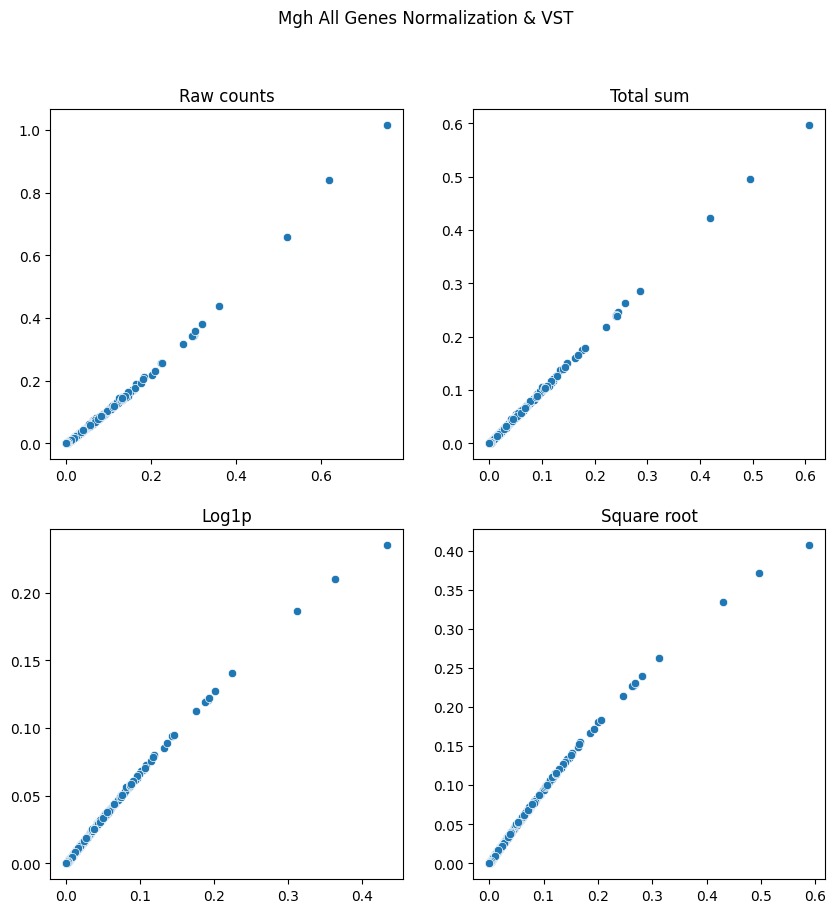

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Mgh All Genes Normalization & VST")

Text(0.5, 0.98, 'Mgh Low And High Abundance Genes Normalization & VST')

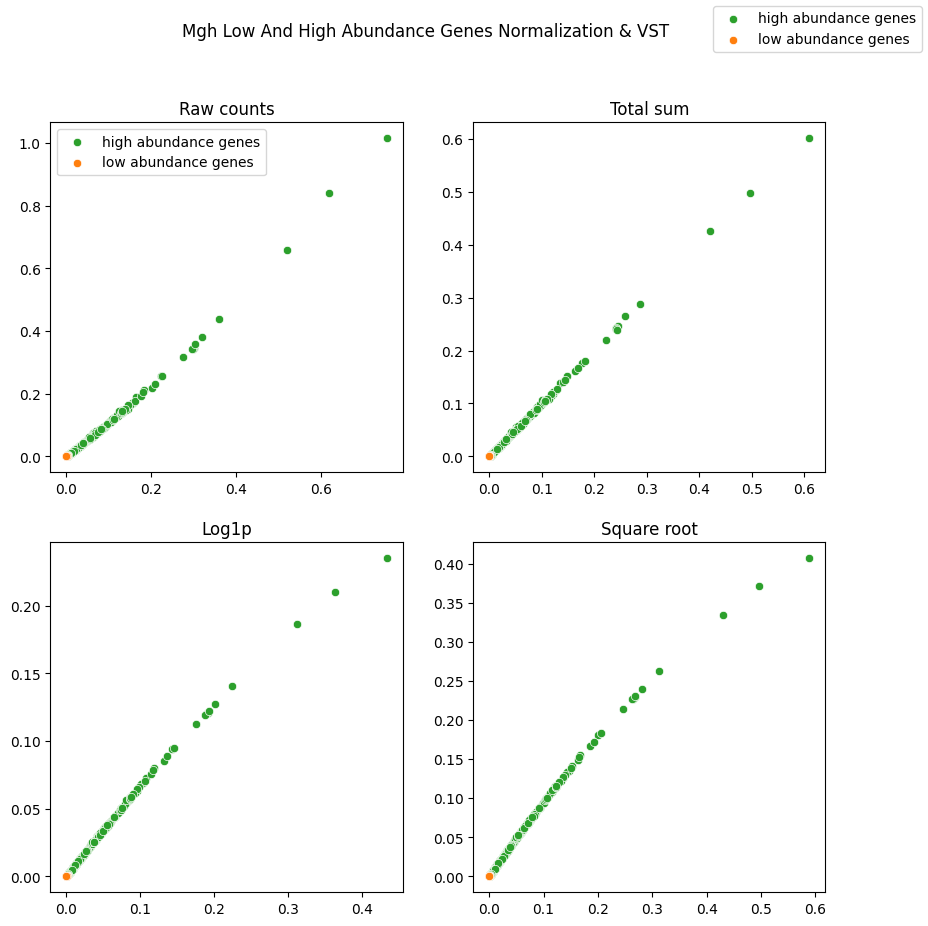

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].X.A, axis=0), 
                color="C2", label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C2", ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C2", ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C2", ax=axes[1][1])


sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.legend()
fig.suptitle("Mgh Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'Mgh Low Abundance Genes Normalization & VST')

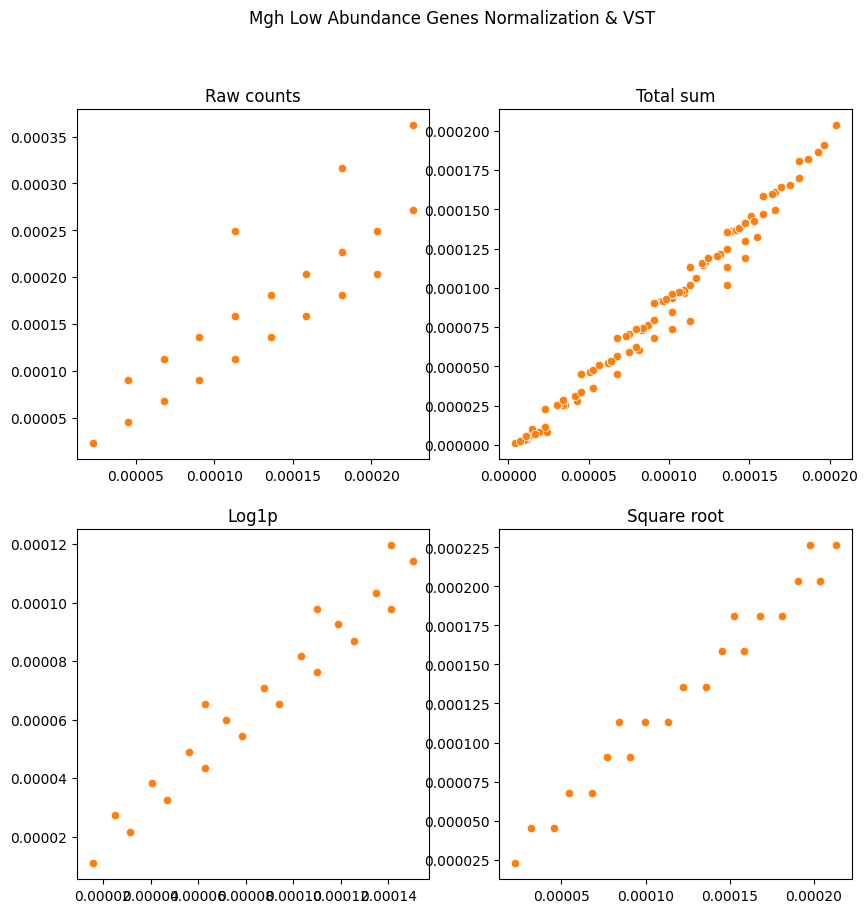

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Mgh Low Abundance Genes Normalization & VST")

In [98]:
print(1 - calc_sparsity(mgh_mudata["all_genes"].X.A))
print(1 - calc_sparsity(mgh_mudata["low_abundance_genes"].X.A))
print(1 - calc_sparsity(mgh_mudata["high_abundance_genes"].X.A))

0.9931527571808777
0.9999142010769622
0.9906936004912663


In [79]:
ec_mudata.write("../data/preprocessed/ec_mudata_preprocessed.h5mu")
efm_mudata.write("../data/preprocessed/efm_mudata_preprocessed.h5mu")
psa_mudata.write("../data/preprocessed/psa_mudata_preprocessed.h5mu")
kp_mudata.write("../data/preprocessed/kp_mudata_preprocessed.h5mu")

#sc.write(filename='../data/preprocessed/mgh_prepro.h5ad', adata=data_gex_mgh)
#sc.write(filename='../data/preprocessed/efm_prepro.h5ad', adata=data_gex_efm)
#sc.write(filename='../data/preprocessed/ec_prepro.h5ad', adata=data_gex_ec)
#sc.write(filename='../data/preprocessed/psa_prepro.h5ad', adata=data_gex_psa)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
